# Import modules & define global variables

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from datetime import datetime
from time import time
from winsound import Beep
from math import sqrt
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.stats import zscore
from statsmodels.stats.proportion import proportions_ztest
from IPython.display import Markdown
import matplotlib.cm as cm

state = 0
t0 = time()
# Paths to save code ouputs, optimized weights, distance matrices, metrics & graphs
path = 'Code outputs/'
d_path = 'Code outputs/Fair Relabeling/Distance matrices/'
w_path = 'Code outputs/Fair Relabeling/Weights/'
m_path = 'Code outputs/Metrics/'
g_path = 'Code outputs/Graphs/'

# Functions

### Data cleaning

In [2]:
def drop_constant_cols(df):
    """
    Drop all constant and empty columns of dataframe
    
    :param df: dataframe with constant/empty columns
    :return: dataframe without constant/empty columns
    """
    
    dropped_cols = []
    for col in df:
        if df[col].nunique() < 2:
            df = df.drop([col], axis=1)
            dropped_cols.append(col)
    print(f'Dropped constant columns: {dropped_cols}')
    print()
    return df

In [3]:
def ordinal_encode(df_copy, enc_cols):
    """
    Ordinal encode attributes, this function is also used for attributes with no natural order,
    since some functions require numerical attributes

    :param df_copy: dataframe with all (mixed type) data
    :param enc_cols: list with column names to encode
    :return: dataframe with ordinal encoded attributes
    """

    df = df_copy.copy()
    all_cols = list(df)
    oe = OrdinalEncoder()
    # Remove missing values before encoding because missing values are also encoded!
    x_enc = oe.fit_transform(df[enc_cols]).astype(int)
    df = df.drop(enc_cols, axis=1)
    # Need to reset index of df, because index of pd.DataFrame(x_enc, columns=enc_cols) is also resetted
    df = df.reset_index(drop=True)
    df[enc_cols] = pd.DataFrame(x_enc, columns=enc_cols)
    # Change order of columns to original order
    df = df[all_cols]
    return df

### Data exploration

In [4]:
def print_df_info(df, c=None, extra=None):
    """
    Prints shape of df, % of duplicate rows, %/size of deprived/favored group

    :param df: dataframe, second column should be sensitive attribute
    :param c: column to print histogram of
    :param extra: whether to print the columns that are at risk of having an average binsize smaller than 70
    :return: None
    """
    
    s = df.columns[1]

    print(f'Shape of df: {df.shape}')
    print(f'Percentage of duplicate rows: {round((len(df) - len(df.drop_duplicates())) / df.shape[0], 4)}')
    print(f'Percentage of duplicate rows (attributes only): '
          f'{round((len(df.iloc[:, 1:]) - len(df.iloc[:, 1:].drop_duplicates())) / df.shape[0], 4)}')
    print()
    print(f'Value count for {s}:\n{df[s].value_counts()}')
    print()
    print(f'Percentage for {s}:\n{df[s].value_counts(normalize=True).round(4)}')
    print()
    exclude_cols = []
    for col in df:
        if df[col].nunique() != 0:
            if df.shape[0] / df[col].nunique() < 70:
                if extra:
                    average_bin_size = round(df.shape[0] / df[col].nunique(), 1)
                    print(col, f'({df[col].dtype})')
                    print(f'Number of unique values: {df[col].nunique()} ({average_bin_size})')
                    print(f'Unique values: {df[col].unique()}')
                    print()
                exclude_cols.append(col)
        else:
            exclude_cols.append(col)
    if extra:
        print(exclude_cols)
    if c is not None:
        print(f'Unique values in {c}: {np.sort(df[s].unique())}')
        print()
        df.hist(col=c)
        print()
    return

### Detect group unfairness

In [5]:
def get_d_all(df):
    """
    Returns all discrimination in a dataframe

    :param df: dataframe (column 0 = class_label (positive decision = 1),
    column 1 = sensitive attribute (deprived group = 1))
    :return: D_all
    """

    c = df.columns[0]
    s = df.columns[1]
    
    n_f_plus = df[(df[s] == 0) & (df[c] == 1)].shape[0]
    n_f = df[df[s] == 0].shape[0]
    n_d_plus = df[(df[s] == 1) & (df[c] == 1)].shape[0]
    n_d = df[df[s] == 1].shape[0]
    if n_f > 0 and n_d > 0:
        d_all = n_f_plus / n_f - n_d_plus / n_d
    elif n_f > 0:
        d_all = n_f_plus / n_f
    else:
        d_all = - n_d_plus / n_d
    
    return d_all

In [6]:
def get_d_unfair(df, cat_cols, e=None, n_bins=[10], print_vc=False, export=False, name=''):
    """
    Calculate D_u (and value count) for number of bins specified in n_bins

    :param df: dataframe (column 0 = class_label (positive decision = 1),
    column 1 = sensitive attribute (deprived group = 1), column 2 = explanatory attribute)
    :param cat_cols: list with column names of categorical attributes in df
    :param e: list with explanatory attribute(s) (default=None)
    :param n_bins: list with number of bins used to discretize the explanatory attribute 
    (this parameter only influences numerical (!='object') explanatory attributes) (default=[10])
    :param print_vc: print value count for discretized explanatory attributes) (default=True)
    :param export: whether to export d_unfairs_df to an Excel file or not (default=True)
    :param name: name of dataset (default='')
    :return: D_u
    """
    
    global t0

    t0 = time()
    
    c = df.columns[0]
    s = df.columns[1]
    if e is None:
        e = [df.columns[2]]    
    
    df_d = df.copy()
    d_all = get_d_all(df_d)
    
    d_unfairs_df = pd.DataFrame(index=e)
    svcs_df = pd.DataFrame(index=e)
    
    for n in n_bins:
        num_cols = []
        d_fairs = []
        svcs = []
        for a in e:
            if a not in cat_cols:
                # Creating more bins than unique values is not necessarily wrong, 
                # since new data might add new unique values 
                # and more bins (empty bins) might reflect the distribution of the original data better
                df_d[a] = pd.cut(df_d[a], n, labels=False)
                num_cols.append(a)
                vcs = df_d[a].value_counts().sort_values()
                if print_vc:
                    # Value counts are printed to check for small bins
                    print(f'Value count for {a} (discretized):\n{vcs}')
                    print()
            else:      
                vcs = df_d[a].value_counts().sort_values()
            e_values = df_d[a].unique().tolist()
            d_fair = 0
            for i in e_values:
                if df_d[df_d[s] == 0].shape[0] != 0:
                    p_e_f = df_d[(df_d[s] == 0) & (df_d[a] == i)].shape[0] / df_d[df_d[s] == 0].shape[0]
                else:
                    p_e_f = 0
                if df_d[df_d[s] == 1].shape[0] != 0:
                    p_e_d = df_d[(df_d[s] == 1) & (df_d[a] == i)].shape[0] / df_d[df_d[s] == 1].shape[0]
                else:
                    p_e_d = 0
                if df_d[(df_d[s] == 0) & (df_d[a] == i)].shape[0] != 0:
                    p_c_e_f = df_d[(df_d[s] == 0) & (df_d[a] == i) & (df_d[c] == 1)].shape[0] / \
                              df_d[(df_d[s] == 0) & (df_d[a] == i)].shape[0]
                else:
                    p_c_e_f = 0
                if df_d[(df_d[s] == 1) & (df_d[a] == i)].shape[0] != 0:
                    p_c_e_d = df_d[(df_d[s] == 1) & (df_d[a] == i) & (df_d[c] == 1)].shape[0] / \
                              df_d[(df_d[s] == 1) & (df_d[a] == i)].shape[0]
                else:
                    p_c_e_d = 0
                p_star = (p_c_e_f + p_c_e_d) / 2
                d_fair += (p_e_f - p_e_d) * p_star
            d_fairs.append(d_fair)
            svcs.append(vcs.iloc[0])
            # Need to set df_d[a] to original column otherwise loop will continue with discretized column
            df_d[a] = df[a]
        d_unfairs_df[n] = [d_all - d for d in d_fairs]
        svcs_df[n] = svcs
    d_unfairs_df = d_unfairs_df.sort_values(by=[n_bins[0]])
    svcs_df = svcs_df.reindex(d_unfairs_df.index)
    if export:
        d_unfairs_df.to_excel(f'{path}{name}_d_unfairs.xlsx')
        svcs_df.to_excel(f'{path}{name}_smallest_value_counts.xlsx')
    if len(n_bins) != 1:
        total = (time() - t0) / 60
        print(f'Total runtime (in minutes): {round(total, 2)}')
    if len(e) == 1 and len(n_bins) == 1:
        d_unfairs_df = d_unfairs_df.iloc[0, 0]
    return d_unfairs_df

In [7]:
def cdp_me(df_copy, w, cat_cols, nom_cols, k_opt, n_bins=[10]):
    """
    Plots silhouette scores per cluster for a different number of clusters using k-means clustering and 
    calculates D_u for each cluster for the optimal number of clusters

    :param df_copy: dataframe (column 0 = class_label (positive decision = 1),
    column 1 = sensitive attribute (deprived group = 1), column 2 = explanatory attribute)
    :param w: array with attribute weigths
    :param cat_cols: list with column names of categorical attributes in df (needed for NBS)
    :param nom_cols: list with column names of nominal attributes in df (needed for one-hot-encoding)
    :param k_opt: optimal number of clusters
    :param n_bins: number of bins used to discretize the explanatory attribute (default=[10])
    :return:
    """

    df = df_copy.copy()
    x = df.iloc[:, 2:]
    # Reset column indices, because df contains indices for the class label and sensitive attribute too
    x.columns = range(x.columns.size)
    x = x.iloc[:, np.where(w > 0.01)[0]]
    nom_cols_01 = [value for value in x.columns if value in nom_cols]

    if nom_cols_01:
        print(nom_cols_01)
        enc = OneHotEncoder()
        # Remove missing values before encoding because missing values are also encoded!
        x_enc = enc.fit_transform(x[nom_cols_01])
        x = x.drop(nom_cols_01, axis=1)
        # Need to reset index of x, because index of pd.DataFrame(x_enc, columns=nom_cols_01) is also resetted
        x = x.reset_index(drop=True)
        x[nom_cols_01] = pd.DataFrame(x_enc, columns=nom_cols_01)

    x_s = zscore(x)
    s_cluster_mean = []
    plt.close('all')
    plt.rcParams.update({'font.size': 9})
    for k in range(2, 21):
        fig, ax = plt.subplots()
        ax.set_xlim([-0.16, 1])
        # ax.set_ylim([0, len(x_s) + (k + 1) * 10])
        kmeans = KMeans(n_clusters=k, random_state=state, n_init='auto')
        cluster_labels = kmeans.fit_predict(x_s)
        s_mean = silhouette_score(x_s, cluster_labels)
        s_cluster_mean.append(s_mean)
        sample_silhouette_values = silhouette_samples(x_s, cluster_labels)
        y_lower = 10

        for i in range(k):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            p_negative_s = round((np.where(ith_cluster_silhouette_values < 0)[0].shape[0] / size_cluster_i) * 100)
            y_upper = y_lower + size_cluster_i
            color = cm.nipy_spectral(float(i) / k)
            ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color,
                             edgecolor=color, alpha=0.7, )
            ax.text(-0.14, y_lower + 0.5 * size_cluster_i, str(i) + ' (' + str(p_negative_s) + '%)')
            y_lower = y_upper + 10

        ax.set_xlabel(f"Silhouette score (k={k})")
        ax.set_ylabel("Cluster label")
        ax.axvline(x=s_mean, color="red", linestyle="--", label=f'Mean={round(s_mean, 2)}')
        ax.set_yticks([])
        ax.legend()
    plt.show()

    plt.plot(range(2, 21), s_cluster_mean)
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette score')
    plt.show()
    print(f'Silhouette scores:\n{s_cluster_mean}')
    print()

    df['cluster'] = KMeans(n_clusters=k_opt, random_state=state, n_init='auto').fit(x_s).labels_
    print(f"Silhouette score for k={k_opt}: {round(silhouette_score(x_s, df['cluster']), 2)}")

    d_all = []
    d_u = []
    for label in df['cluster'].unique():
        d_all.append(round(get_d_all(df.loc[df['cluster'] == label]), 2))
        d_u.append(round(get_d_unfair(df.loc[df['cluster'] == label], cat_cols, n_bins=n_bins), 2))
    print(f'D_all in each cluster: {d_all}')
    print(f'D_u in each cluster: {d_u}')
    print(f"Cluster sizes:\n{df['cluster'].value_counts()}")
    return df


In [8]:
def get_minima_d(df, d_matrix):
    """
    Compute the minimum distances between deprived and favored instances and their nearest neighbor

    :param DataFrame df: dataset, where each row is an instance and columns represent features
    :param ndarray d_matrix: distance matrix representing pairwise distances between instances in data
    :return:
        - minima_d_d (ndarray): distances between deprived instances with a negative class label
        and their nearest favored instance
        - minima_d_f (ndarray): distances between favored instances with a positive class label a
        nd their nearest deprived instance
        - d_0_idx (ndarray): indices of deprived instances with a negative class label
        - f_1_idx (ndarray): indices of favored instances with a positive class label
    """
    
    d_idx = df.index[df.iloc[:, 1] == 1].tolist()
    f_idx = df.index[df.iloc[:, 1] == 0].tolist()
    d_0_idx = df.index[(df.iloc[:, 1] == 1) & (df.iloc[:, 0] == 0)].tolist()
    f_1_idx = df.index[(df.iloc[:, 1] == 0) & (df.iloc[:, 0] == 1)].tolist()

    d_rows_d_0 = d_matrix[d_0_idx, :]
    # Distances between X^(d-) and X^f
    d_matrix_d_0_f = d_rows_d_0[:, f_idx]
    minima_d_d = d_matrix_d_0_f.min(axis=1)

    d_rows_f_1 = d_matrix[f_1_idx, :]
    # Distances between X^(f+) and X^d
    d_matrix_f_1_d = d_rows_f_1[:, d_idx]
    minima_d_f = d_matrix_f_1_d.min(axis=1)

    return minima_d_d, minima_d_f, d_0_idx, f_1_idx



In [9]:
def get_max_d_info(df, d_matrix, d, max_d, d_0_idx, f_1_idx, bin_cols, nom_cols, int_cols, ord_cols, w):
    """
    Display information about the instances with maximum distance in the given distance matrix.

    This function finds the instances in the DataFrame that are at the maximum distance specified by `max_d`
    in the distance matrix. It then prints the indices of these instances and their attribute contributions
    to the weighted Podani distance.

    :param pd.DataFrame df: data with attributes, assumes that the relevant attributes are in columns after the first two columns.
    :param np.ndarray d_matrix: distance matrix where distances between instances are stored
    :param bool d: whether max_d is calculated using deprived (True) or favored instances (False)
    :param float max_d: maximum distance value between instances in df
    :param np.ndarray d_0_idx: indices of deprived instances in df
    :param np.ndarray f_1_idx: Indices of favored instances df
    :param list bin_cols: column names corresponding to binary attributes in df
    :param list nom_cols: column names corresponding to nominal attributes in df
    :param list int_cols: column names corresponding to interval-scaled attributes in df
    :param list ord_cols: column names corresponding to ordinal attributes in df
    :param np.ndarray w: weights for each attribute used in the weighted Podani distance calculation

    :return:
    """
    
    max_d_idx = np.where(d_matrix == max_d)
    if d:
        # Find the indice of the deprived instance with a negative class label at distance max_d
        max_d_d_idx = np.intersect1d(max_d_idx[0], d_0_idx)[0]
        # Find the index of the favored instance that lies at distance max_d from instance at index max_d_d_idx
        max_d_f_idx = max_d_idx[1][np.where(max_d_idx[0] == max_d_d_idx)[0]][0]
    else:
        # Find indices of favored instances with a positive class label at distance max_d
        max_d_f_idx = np.intersect1d(max_d_idx[0], f_1_idx)[0]
        # Find the index of the deprived instance that lies at distance max_d from instance at index max_d_f_idx
        max_d_d_idx = max_d_idx[1][np.where(max_d_idx[0] == max_d_f_idx)[0]][0]

    print(f"Indices of deprived and favored instance at maximum distance of {round(max_d, 2)}: {max_d_d_idx}, "
          f"{max_d_f_idx}\n")

    print(f'Attribute contributions to the distance of {round(max_d, 2)}:')
    df_x = df.iloc[:, 2:]
    x_d = df_x.loc[max_d_d_idx].to_numpy()
    x_f = df_x.loc[max_d_f_idx].to_numpy()

    cols_range = (df_x.max() - df_x.min()).to_numpy()
    bin_idx = np.array(df_x.columns.get_indexer(bin_cols))
    nom_idx = np.array(df_x.columns.get_indexer(nom_cols))
    int_idx = np.array(df_x.columns.get_indexer(int_cols))
    ord_idx = np.array(df_x.columns.get_indexer(ord_cols))

    _ = weighted_podani_distance(x_d, x_f, w, bin_idx, nom_idx, int_idx, ord_idx, cols_range, 1)
    display(df.loc[[max_d_d_idx, max_d_f_idx]])
    return


In [10]:
def get_cluster_info(df_clustered, w, bin_cols, nom_cols, int_cols, ord_cols, d_matrix, m, name, k, cluster=-1, d=True):
    """
    Analyze and display cluster information

    :param DataFrame df_clustered: clustered data with cluster labels in the last column
    :param np.array w: weights for the attributes used in distance calculation
    :param list bin_cols: column names corresponding to binary attributes
    :param list nom_cols: column names corresponding to nominal attributes
    :param list int_cols: column names corresponding to interval-scaled attributes
    :param list ord_cols: column names corresponding to ordinal attributes
    :param np.array d_matrix: distance matrix containing distances between all instances in df_clustered
    :param int m: maximum allowable distance for two instances to be considered similar/near, 
    used to calculate unfairness scores
    :param str name: name of dataset
    :param int k: number of nearest neighbors used to calculate D_k-scores
    :param int cluster: cluster label to analyze (default=-1)
    :param bool d: whether to use the maximum distance of deprived or favored instances (default=True)

    :return:
    """

    info_clusters = np.empty(shape=(0, 10))

    for label in df_clustered['cluster'].unique():
        df_cluster = df_clustered.loc[df_clustered['cluster'] == label].drop('cluster', axis=1)
        d_matrix_cluster = get_d_matrix(df_cluster, w, bin_cols, nom_cols, int_cols, ord_cols, print_info=0)
        minima_d_d, minima_d_f, d_0_idx, f_1_idx = get_minima_d(df_cluster, d_matrix)
        _, _, _, _, info_cluster = get_unfair_instances(df_cluster.to_numpy(), d_matrix_cluster, m, name, k,
                                                        print_info=0)
        max_d_d = minima_d_d.max()
        max_d_f = minima_d_f.max()
        info_clusters = np.vstack(
            (info_clusters, [label, df_cluster.shape[0]] + info_cluster + [max_d_d, max_d_f]))
        if label == cluster:
            if d:
                get_max_d_info(df_cluster, d_matrix, d, max_d_d, d_0_idx, f_1_idx, bin_cols, nom_cols, int_cols,
                               ord_cols, w)
            else:
                get_max_d_info(df_cluster, d_matrix, d, max_d_f, d_0_idx, f_1_idx, bin_cols, nom_cols, int_cols,
                               ord_cols, w)

    info_cols = ['cluster label', 'cluster size', 'deprived', 'favored', 'no neighbors', 'assumptions unmet',
                 'insignificant',
                 'unfair instances', 'maximum distance (deprived)', 'maximum distance (favored)']
    df_info_clusters = pd.DataFrame(info_clusters, columns=info_cols)
    df_info_clusters[info_cols[:-2]] = df_info_clusters[info_cols[:-2]].astype(int)
    display(df_info_clusters.style.format(
        {'maximum distance (deprived)': '{:.2f}', 'maximum distance (favored)': '{:.2f}'}).background_gradient(
        cmap="RdYlGn"))

    return


### Optimize weights

In [11]:
@jit(nopython=True)
def sum_ddw_distances(p, ddw_distances):
    """
    Sum ddw_distances per attribute

    :param p: number of attributes
    :param ddw_distances: nested list with ddw_distances
    :return: gradient
    """

    gradient = []
    for i in range(p):
        sum_d = 0
        for d in range(len(ddw_distances)):
            sum_d += ddw_distances[d][i]
        gradient.append(sum_d)
    return gradient

In [12]:
@jit(nopython=True)
def get_ddw_distances(data, c, bin_idx, nom_idx, int_idx, ord_idx, cols_range):
    """
    Compute the derivative of the distance for all instances with the same and a different class label in data 

    :param data: ndarray with data
    :param c: array with class labels
    :param bin_idx: array with column indices of binary attributes in data
    :param nom_idx: array with column indices of nominal attributes in data
    :param int_idx: array with column indices of interval-scaled attributes in data
    :param ord_idx: array with column indices of ordinal attributes in data
    :param cols_range: array with range for each column
    :return: two arrays with derivative distances between instances
    """
    
    d2_ddw_same_c = []
    d2_ddw_diff_c = []

    for x in range(0, len(c)):
        for y in range(x + 1, len(c)):
            d2_ddw = []
            for col in range(0, len(data[x])):
                if col in bin_idx or (col in nom_idx and data[x][col] == data[y][col]):
                    d2_ddw.append((data[x][col] - data[y][col]) ** 2)
                if col in nom_idx and data[x][col] != data[y][col]:
                    d2_ddw.append(1)
                if (col in int_idx) or (col in ord_idx):
                    d2_ddw.append(((data[x][col] - data[y][col]) / cols_range[col]) ** 2)
            if c[x] == c[y]:
                d2_ddw_same_c.append(d2_ddw)
            else:
                d2_ddw_diff_c.append(d2_ddw)
    return np.array(d2_ddw_same_c), np.array(d2_ddw_diff_c)

In [13]:
def podani_gradient(w, x_d, x_f, y_d, y_f, bin_idx, nom_idx, int_idx, ord_idx, cols_range, λ):
    """
    Gradient of objective function in minimize_weighted_podani

    :param w: array with attribute weights
    :param x_d: attributes deprived group
    :param x_f: attributes favored group
    :param y_d: class labels deprived group
    :param y_f: class labels favored group
    :param bin_idx: array with column indices of binary attributes in X
    :param nom_idx: array with column indices of nominal attributes in X
    :param int_idx: array with column indices of interval-scaled attributes in X
    :param ord_idx: array with column indices of ordinal attributes in X
    :param cols_range: array with range for each column
    :param λ: λ to multiply derivative of squared L2 norm with
    :return: objective function
    """

    ddw_d2_d_same, ddw_d2_d_diff = get_ddw_distances(x_d, y_d, bin_idx, nom_idx, int_idx, ord_idx, cols_range)
    ddw_d2_f_same, ddw_d2_f_diff = get_ddw_distances(x_f, y_f, bin_idx, nom_idx, int_idx, ord_idx, cols_range)

    gradient_d_same = (1 / len(ddw_d2_d_same)) * np.array(sum_ddw_distances(len(x_d[0]), ddw_d2_d_same))
    gradient_d_diff = (1 / len(ddw_d2_d_diff)) * np.array(sum_ddw_distances(len(x_d[0]), ddw_d2_d_diff))
    gradient_f_same = (1 / len(ddw_d2_f_same)) * np.array(sum_ddw_distances(len(x_d[0]), ddw_d2_f_same))
    gradient_f_diff = (1 / len(ddw_d2_f_diff)) * np.array(sum_ddw_distances(len(x_d[0]), ddw_d2_f_diff))

    gradient = gradient_d_same + gradient_f_same - gradient_d_diff - gradient_f_diff

    for i in range(len(w)):
        gradient[i] += 2 * λ * w[i]
    return gradient

In [14]:
@jit(nopython=True)
def get_distances(data, c, w, bin_idx, nom_idx, int_idx, ord_idx, cols_range):
    """
    Compute distance between all instances with the same and a different class label in data

    :param data: ndarray with data
    :param c: array with class labels
    :param w: array with attribute weights
    :param bin_idx: array with column indices of binary attributes in data
    :param nom_idx: array with column indices of nominal attributes in data
    :param int_idx: array with column indices of interval-scaled attributes in data
    :param ord_idx: array with column indices of ordinal attributes in data
    :param cols_range: array with range for each column
    :return: two lists with distances between instances
    """

    d2_diff_c = []
    d2_same_c = []
    for x in range(0, len(c)):
        for y in range(x + 1, len(c)):
            d2 = []
            for col in range(0, len(data[x])):
                if col in bin_idx or (col in nom_idx and data[x][col] == data[y][col]):
                    d2.append(w[col] * ((data[x][col] - data[y][col]) ** 2))
                if col in nom_idx and data[x][col] != data[y][col]:
                    d2.append(w[col])
                if (col in int_idx) or (col in ord_idx):
                    d2.append(w[col] * (((data[x][col] - data[y][col]) / cols_range[col]) ** 2))
            sum_d2 = sum(d2)
            if c[x] == c[y]:
                d2_same_c.append(sum_d2)
            else:
                d2_diff_c.append(sum_d2)
    return d2_same_c, d2_diff_c

In [15]:
def objective_weighted_podani(w, x_d, x_f, y_d, y_f, bin_idx, nom_idx, int_idx, ord_idx, cols_range, λ):
    """
    Objective function to minimize in minimize_weighted_podani

    :param w: array with attribute weights
    :param x_d: attributes deprived group
    :param x_f: attributes favored group
    :param y_d: class labels deprived group
    :param y_f: class labels favored group
    :param bin_idx: array with column indices of binary attributes in X
    :param nom_idx: array with column indices of nominal attributes in X
    :param int_idx: array with column indices of interval-scaled attributes in X
    :param ord_idx: array with column indices of ordinal attributes in X
    :param cols_range: array with range for each column
    :param λ: λ to multiply squared L2 norm with
    :return: objective function
    """

    d2_d_same, d2_d_diff = get_distances(x_d, y_d, w, bin_idx, nom_idx, int_idx, ord_idx, cols_range)
    d2_f_same, d2_f_diff = get_distances(x_f, y_f, w, bin_idx, nom_idx, int_idx, ord_idx, cols_range)

    f_w = sum(d2_d_same) / len(d2_d_same) + sum(d2_f_same) / len(d2_f_same) - sum(d2_d_diff) / len(d2_d_diff) - sum(
        d2_f_diff) / len(d2_f_diff)

    l2_norm = λ * sum(w ** 2)

    return f_w + l2_norm

In [16]:
def get_w(df_copy, bin_cols, nom_cols, int_cols, ord_cols, name, start_w=np.nan, save=False):
    """
    Get weights by minimizing objective_weighted_podani using the complete dataset. 
    The values of the weights should be such that instances with the same class label will have a small distance 
    between each other and instances with different class label will have large distances between each other.

    :param df_copy: dataframe (column 0 = class_label (positive decision = 1),
    column 1 = sensitive attribute (deprived group = 1))
    :param bin_cols: list with column names of binary attributes in df_copy
    :param nom_cols: list with column names of nominal attributes in df_copy
    :param int_cols: list with column names of interval-scaled attributes in df_copy
    :param ord_cols: list with column names of ordinal attributes in df_copy
    :param name: name of dataset
    :param start_w: starting values for w (default=None)
    :param save: whether to save the weights in an Excel file or not (default=False)
    :return: None
    """

    global t0

    df = df_copy.copy()
    df_x = df.iloc[:, 2:]

    # Ranges have to be calculated based on whole dataframe for Podani distance
    cols_range = (df_x.max() - df_x.min()).to_numpy()

    df_d = df[df.iloc[:, 1] == 1]
    df_f = df[df.iloc[:, 1] == 0]
    x_d = df_d.iloc[:, 2:].to_numpy()
    x_f = df_f.iloc[:, 2:].to_numpy()
    y_d = df_d.iloc[:, 0].to_numpy()
    y_f = df_f.iloc[:, 0].to_numpy()

    bin_idx = np.array(df_x.columns.get_indexer(bin_cols))
    nom_idx = np.array(df_x.columns.get_indexer(nom_cols))
    int_idx = np.array(df_x.columns.get_indexer(int_cols))
    ord_idx = np.array(df_x.columns.get_indexer(ord_cols))

    print(f'Columns excluded from optimization: {list(df.columns[:2])}')
    print()
    if not save:
        print('Weights are not saved in an Excel file for each λ-value!')

    bnds = [(1e-14, float('inf'))] * x_d.shape[1]
    if np.isnan(start_w):
        start_w = [0.1] * x_d.shape[1]

    # λs = [0.4, 0.38, 0.36, 0.34, 0.32, 0.3, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.09, 0.08, 0.07,
    #       0.06, 0.05, 0.03]
    λs = [0.09]
    w = []
    fun = []

    if len(λs) > 1:
        save_name = 'w_' + name + '_' + str(df_copy.shape[0])
        # Save empty dataframe to check if Excel file is closed, before optimization
        pd.DataFrame().to_excel(f'{w_path}{save_name}.xlsx')
    
    t0 = time()
    print(f'Time when starting optimizing weights: {datetime.now().strftime("%H:%M:%S")}')

    for idx, λ in enumerate(λs):
        # Save empty dataframe to check if Excel file is closed, before optimization
        save_name = 'w_' + name + '_' + str(df_copy.shape[0]) + '_' + str(λ)
        if save:
            pd.DataFrame().to_excel(f'{w_path}{save_name}.xlsx')

        print()
        print(f'λ = {λ}')
        t1 = time()
        sol = minimize(objective_weighted_podani, start_w,
                       (x_d, x_f, y_d, y_f, bin_idx, nom_idx, int_idx, ord_idx, cols_range, λ),
                       method='SLSQP', jac=podani_gradient, bounds=bnds)
        w.append(sol['x'])
        fun.append(sol['fun'])

        if save:
            pd.DataFrame(w[idx], index=df.columns[2:], columns=['w']).to_excel(
                f'{w_path}{save_name}.xlsx')
        time_passed = round((time() - t1) / 60, 2)
        print(f'{time_passed}: fun = {fun[idx]}, w = {w[idx]}')

    if len(λs) > 1:
        save_name = 'w_' + name + '_' + str(df_copy.shape[0])
        indices = list(df.columns[2:])
        indices.insert(0, 'f_w')
        pd.DataFrame(np.insert(np.transpose(np.array(w)), 0, fun, axis=0), index=indices, columns=λs).to_excel(
            f'{w_path}{save_name}.xlsx')

    total = (time() - t0) / 60
    print()
    print(f'Total runtime (in minutes): {round(total, 2)}')
    if total > 1:
        Beep(600, 1500)

    return w

### Detect unfair instances

In [17]:
@jit(nopython=True)
def weighted_podani_distance(x, y, w, bin_idx, nom_idx, int_idx, ord_idx, cols_range, print_w=False):
    """
    Calculate distance between x and y with weighted Podani distance function

    :param x: observation x
    :param y: observation y
    :param w: array with attribute weigths
    :param bin_idx: array with column indices of binary attributes in x & y
    :param nom_idx: array with column indices of nominal attributes in x & y
    :param int_idx: array with column indices of interval-scaled attributes in x & y
    :param ord_idx: array with column indices of ordinal attributes in x & y
    :param cols_range: array with range for each column
    :return: distance between x and y
    """

    wd = []
    for col in range(0, len(x)):
        if col in bin_idx or (col in nom_idx and x[col] == y[col]):
            wd.append((w[col] * ((x[col] - y[col]) ** 2))[0])
        if col in nom_idx and x[col] != y[col]:
            wd.append((w[col])[0])
        if (col in int_idx) or (col in ord_idx):
            # If the range of a column is zero, all attribute values of this column are similar
            if cols_range[col] > 0:
                wd.append((w[col] * (((x[col] - y[col]) / cols_range[col]) ** 2))[0])
            else:
                wd.append(0)
                
    if print_w:
        print(wd)
    sum_wd = sum(wd)
    
    return sqrt(sum_wd)
    

In [18]:
def get_d_matrix(df, w, bin_cols, nom_cols, int_cols, ord_cols, print_info=True):
    """
    Compute distance matrix (excluding the sensitive attribute) for df using weighted_podani_distance

    :param df: dataframe (column 0 = class_label (positive decision = 1),
    column 1 = sensitive attribute (deprived group = 1))
    :param w: array with attribute weigths
    :param bin_cols: list with column names of binary attributes in df
    :param nom_cols: list with column names of nominal attributes in df
    :param int_cols: list with column names of interval-scaled attributes in df
    :param ord_cols: list with column names of ordinal attributes in df    
    :param print_info: whether to print information about calculating the distance matrix (default=True)
    :return: distance matrix
    """

    # Exclude class label and sensitive attribute for X
    x = df.iloc[:, 2:]

    cols_range = (x.max() - x.min()).to_numpy()

    bin_idx = np.array(x.columns.get_indexer(bin_cols))
    nom_idx = np.array(x.columns.get_indexer(nom_cols))
    int_idx = np.array(x.columns.get_indexer(int_cols))
    ord_idx = np.array(x.columns.get_indexer(ord_cols))

    x = x.to_numpy()

    t_start = time()
    if print_info:
        print(f'Time when starting calculating d_matrix: {datetime.now().strftime("%H:%M:%S")}')

    d_matrix = cdist(x, x, weighted_podani_distance, w=w, bin_idx=bin_idx, nom_idx=nom_idx, int_idx=int_idx,
                     ord_idx=ord_idx, cols_range=cols_range)

    total = (time() - t_start) / 60
    if print_info:
        print(f'Total runtime (in minutes): {round(total, 2)}')
    if total > 1:
        Beep(600, 1500)

    return d_matrix

In [19]:
def get_m(df, d_matrix, name, bin_cols, nom_cols, int_cols, ord_cols, w, plot=True, save=True):
    """
    Calculate and visualize the distance threshold 'm' for a dataset based on distances between instances 
    and their nearest neighbors

    :param DataFrame df: data
    :param ndarray d_matrix: distance matrix of for instances in df
    :param str name: name of dataset
    :param list bin_cols: binary columns in df
    :param list nom_cols: nominal columns in df
    :param list int_cols: interval-scaled columns df
    :param list ord_cols: ordinal columns in df
    :param ndarray w: attribute weights to calculate weighted podani's distance
    :param bool plot: whether to display the plots (default=True)
    :param bool save: whether to save the plots as images (default=True)
    :return: distance threshold 'm'
    """

    data = df.to_numpy()
    minima_d_d, minima_d_f, d_0_idx, f_1_idx = get_minima_d(df, d_matrix)

    np.fill_diagonal(d_matrix, d_matrix.max())
    minima_d = d_matrix.min(axis=1)
    m = np.quantile(minima_d, 0.75) + 1.5 * np.subtract(*np.percentile(minima_d, [75, 25]))

    # k_d = np.count_nonzero(d_matrix_d_0_f <= m) / d_matrix_d_0_f.shape[0]
    # k_f = np.count_nonzero(d_matrix_f_1_d <= m) / d_matrix_f_1_d.shape[0]

    plt.close('all')
    # plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams.update({'lines.linewidth': 2, 'font.size': 18})
    # fig, axs = plt.subplots(1, 2, figsize=(12.8, 4.8))

    fig, ax = plt.subplots()
    n, bins, _ = plt.hist(minima_d, bins='rice', color='k', alpha=0.7)
    plt.axvline(m, alpha=0.4, c='k', label=f'm≈{round(m, 3)}', linestyle='dashed')
    plt.xlabel('Distance between x and nearest neighbor', fontsize=16)
    plt.ylabel('Frequence', fontsize=16)
    plt.legend()
    fig.set_size_inches(6.647, 3.91)
    if save:
        plt.savefig(f'{g_path}hist_minima_d_{name}_1.png', bbox_inches='tight', dpi=300, pad_inches=0.01)
    if plot:
        plt.show()

    freq_max = np.argmax(n)
    center_bin = (bins[freq_max] + bins[freq_max + 1]) / 2
    print(f'Maximum distance: {round(minima_d.max(), 2)}')
    print(f'Median distance: {round(np.median(minima_d), 2)}')
    print(f'Center of largest bin: {round(center_bin, 2)}')
    print()

    fig, ax = plt.subplots()
    n, bins, _ = plt.hist(minima_d_d, bins='rice', color='k', alpha=0.7)
    plt.axvline(m, alpha=0.4, c='k', label=f'm≈{round(m, 3)}', linestyle='dashed')
    plt.xlabel('Distance between x and nearest favored x\'', fontsize=16)
    plt.ylabel('Frequence', fontsize=16)
    plt.legend()
    fig.set_size_inches(6.647, 3.91)
    if save:
        plt.savefig(f'{g_path}hist_minima_d_{name}_2.png', bbox_inches='tight', dpi=300, pad_inches=0.01)
    if plot:
        plt.show()

    freq_max = np.argmax(n)
    center_bin = (bins[freq_max] + bins[freq_max + 1]) / 2
    # row_idx, col_idx = np.where(d_matrix == max_d_d)
    # idx = np.concatenate((d_0_idx, f_idx))
    print(f'Center of largest bin: {round(center_bin, 2)}')
    get_max_d_info(df, d_matrix, 1, minima_d_d.max(), d_0_idx, f_1_idx, bin_cols, nom_cols, int_cols, ord_cols, w)
    print()

    fig, ax = plt.subplots()
    n, bins, _ = ax.hist(minima_d_f, bins='rice', color='k', alpha=0.7)
    ax.axvline(m, alpha=0.4, c='k', label=f'm≈{round(m, 3)}', linestyle='dashed')
    ax.set_xlabel('Distance between x and nearest deprived x\'', fontsize=16)
    ax.set_ylabel('Frequence', fontsize=16)
    ax.legend()
    fig.set_size_inches(6.647, 3.91)
    if save:
        plt.savefig(f'{g_path}hist_minima_d_{name}_3.png', bbox_inches='tight', dpi=300, pad_inches=0.01)
    if plot:
        plt.show()

    freq_max = np.argsort(n)[::-1][:3]
    # Assuming the modes are at the first three largest bins, 
    # where the modes end up depends on the method used to calculate the optimal binwidth
    center_bin_1 = (bins[freq_max[0]] + bins[freq_max[0] + 1]) / 2
    center_bin_2 = (bins[freq_max[1]] + bins[freq_max[1] + 1]) / 2
    center_bin_3 = (bins[freq_max[2]] + bins[freq_max[2] + 1]) / 2
    # row_idx, col_idx = np.where(d_matrix == max_d_f)
    # idx = np.concatenate((f_1_idx, d_idx))
    print(f'Centers of the \'modes\': {round(center_bin_1, 2)}, {round(center_bin_2, 2)}, {round(center_bin_3, 2)}')
    get_max_d_info(df, d_matrix, 0, minima_d_f.max(), d_0_idx, f_1_idx, bin_cols, nom_cols, int_cols, ord_cols, w)
    print()

    return m


In [20]:
def get_unfair_instances(data, d_matrix, m, name, k, print_info=True, plot=False, plot_u_score=False, save=False):
    """
    Get indices/unfairness scores/k for unfair instances in data and U, U_n and plot unfairness scores, d_k-scores,
    number of neighbors and p-values

    :param data: ndarray of dataset (column 0 = class_label (positive decision = 1),
    column 1 = sensitive attribute (deprived group = 1), column 2 = explanatory attribute)
    :param d_matrix: ndarray with distance matrix
    :param m: m for measuring unfairness using m-NN
    :param name: name of dataset
    :param k: k for measuring unfairness using k-NN
    :param print_info: whether to print information about the unfair instances (default=True)
    :param plot: whether to plot histograms of the unfairness scores, d_k-scores, number of neighbors and p-values
    (default=False)
    :param plot_u_score: whether to only plot histograms of the unfairness scores (default=False)
    :param save: whether to save the histograms (default=False)
    :return: [index, unfairness score, number of neighbors with different s, number of neighbors with same s,
    p-value two-proportion z-test, p-value one-proportion z-test] for d_m- and f_m-score, U, U_n, info about unfair instances
    """

    d_0_idx = np.where((data[:, 1] == 1) & (data[:, 0] == 0))[0]
    n_d_0 = len(d_0_idx)
    f_1_idx = np.where((data[:, 1] == 0) & (data[:, 0] == 1))[0]
    n_f_1 = len(f_1_idx)
    f_0_idx = np.where((data[:, 1] == 0) & (data[:, 0] == 0))[0]
    d_idx = np.where(data[:, 1] == 1)[0]
    f_idx = np.where(data[:, 1] == 0)[0]

    # Only unfairness scores with a statistical significance level of 0.05 or lower are appended to d_m_nn/f_m_nn
    d_m_nn = []
    f_m_nn = []
    # Only unfairness scores with at least 1 near neighbor with a different sensitive attribute
    # are appended to d_m_nn_all/f_m_nn_all
    d_m_nn_all = []
    f_m_nn_all = []
    d_k_scores = []
    d_k_scores_f = []
    # f_k_scores = []
    n_equal_0 = 0
    p_val_equal_nan = 0
    p_val_insig = 0

    # Find unfair deprived instances due to discrimination
    for i in d_0_idx:
        d_row = d_matrix[i, :]

        # m-NN
        m_idx = np.where(d_row <= m)[0]
        f_m_idx = np.intersect1d(m_idx, f_idx)
        # Exclude the deprived instance i itself
        d_m_idx = np.intersect1d(m_idx, np.delete(d_idx, np.where(d_idx == i)[0]))
        n_f = len(f_m_idx)
        n_d = len(d_m_idx)

        # k-NN
        f_k_idx = np.argpartition(d_row[f_idx], k)[:k]
        data_f = data[f_idx]
        # Exclude the deprived instance i itself
        # d_k_idx = np.argpartition(d_row[np.delete(d_idx, np.where(d_idx == i)[0])], k)[:k]
        # data_d = data[np.delete(d_idx, np.where(d_idx == i)[0])]
        d_k_score = np.mean(data_f[f_k_idx, 0])  # - np.mean(data_d[d_k_idx, 0])
        d_k_scores.append(d_k_score)

        # There's not enough evidence for discrimination for deprived instance i
        # if less than n favored instances are found within a distance m (n_f = 0),
        # therefore the index i should not be added to d_m_nn
        if n_f >= 1:
            p_f = np.mean(data[f_m_idx, 0])
            d_m_score = p_f
            # The average class label of near favored instances should only be compared to the average class label
            # of near deprived instances, if other deprived instances are found within a distance m
            if n_d > 0:
                p_d = np.mean(data[d_m_idx, 0])
                d_m_score -= p_d
            # Strict assumption must hold for two proportion Z-test
            if n_f * p_f >= 5 and n_f * (1 - p_f) >= 5 and n_d * p_d >= 5 and n_d * (1 - p_d) >= 5:
                count = [np.sum(data[f_m_idx, 0]), np.sum(data[d_m_idx, 0])]
                nobs = [n_f, n_d]
                p_val_2 = proportions_ztest(count, nobs)[1]
                # If the assumptions for two proportion Z-test hold the one proportion Z-test should not be conducted
                p_val_1 = np.nan
            # Strict assumption must hold for one proportion Z-test
            elif n_f * p_f >= 5 and n_f * (1 - p_f) >= 5:
                p_val_1 = proportions_ztest(np.sum(data[f_m_idx, 0]), n_f, value=0, alternative='larger')[1]
                p_val_2 = np.nan
            else:
                p_val_2 = p_val_1 = np.nan
                p_val_equal_nan += 1
            if p_val_2 <= 0.05 or p_val_1 <= 0.05:
                d_m_nn.append([i, d_m_score, n_f, n_d, p_val_2, p_val_1])
            if p_val_2 > 0.05 or p_val_1 > 0.05:
                p_val_insig += 1
            d_m_nn_all.append([i, d_m_score, n_f, n_d, p_val_2, p_val_1])
        else:
            n_equal_0 += 1

    # Find unfair favored instances due to favoritism
    for j in f_1_idx:
        d_row = d_matrix[j, :]

        # m-NN
        m_idx = np.where(d_row <= m)[0]
        d_m_idx = np.intersect1d(m_idx, d_idx)
        # Exclude the favored instance j itself
        f_m_idx = np.intersect1d(m_idx, np.delete(f_idx, np.where(f_idx == j)[0]))
        n_d = len(d_m_idx)
        n_f = len(f_m_idx)

        # k-NN
        # d_k_idx = np.argpartition(d_row[d_idx], k)[:k]
        # data_d = data[d_idx]
        # f_k_score = np.mean(data_d[d_k_idx, 0])
        # f_k_scores.append(f_k_score)        

        # There's not enough evidence for favoritism for favored instance j
        # if less than n deprived instances are found within a distance m (n_d = 0),
        # therefore the index j should not be added to f_m_nn
        if n_d >= 1:
            # F_m = proportion of instances with a negative class label = 1 - #instances with a positive class label
            p_d = np.mean(data[d_m_idx, 0])
            f_m_score = 1 - p_d
            # The average class label of near deprived instances should only be compared to the average class label
            # of near favored instances, if other favored instances are found within a distance m
            if n_f > 0:
                p_f = np.mean(data[f_m_idx, 0])
                d_m_score -= 1 - p_f
            # Strict assumption must hold for two proportion Z-test
            if n_d * p_d >= 5 and n_d * (1 - p_d) >= 5 and n_f * p_f >= 5 and n_f * (1 - p_f) >= 5:
                count = [np.sum(data[d_m_idx, 0]), np.sum(data[f_m_idx, 0])]
                nobs = [n_d, n_f]
                p_val_2 = proportions_ztest(count, nobs)[1]
                # If the assumptions for two proportion Z-test hold the one proportion Z-test should not be conducted
                p_val_1 = np.nan
            # Strict assumption must hold for one proportion Z-test
            elif n_d * p_d >= 5 and n_d * (1 - p_d) >= 5:
                p_val_1 = proportions_ztest(np.sum(data[d_m_idx, 0]), n_d, value=1, alternative='smaller')[1]
                p_val_2 = np.nan
            else:
                p_val_1 = p_val_2 = np.nan
                p_val_equal_nan += 1
            if p_val_2 <= 0.05 or p_val_1 <= 0.05:
                f_m_nn.append([j, f_m_score, n_d, n_f, p_val_2, p_val_1])
            if p_val_2 > 0.05 or p_val_1 > 0.05:
                p_val_insig += 1
            f_m_nn_all.append([j, d_m_score, n_f, n_d, p_val_2, p_val_1])
        else:
            n_equal_0 += 1

    # Find unfair favored instances due to discrimination
    for l in f_0_idx:
        d_row = d_matrix[l, :]
        d_k_idx = np.argpartition(d_row[d_idx], k)[:k]
        data_d = data[d_idx]
        d_k_score = np.mean(data_d[d_k_idx, 0])
        d_k_scores_f.append(d_k_score)

    n_u_d = len(d_m_nn)
    n_u_f = len(f_m_nn)
    info = [n_d_0, n_f_1, n_equal_0, p_val_equal_nan, p_val_insig, n_u_d + n_u_f]

    q3 = np.quantile(d_k_scores_f, 0.75)
    iqr = np.subtract(*np.percentile(d_k_scores_f, [75, 25]))
    t = q3 + 1.5 * iqr
    if print_info:
        print(f'Number of deprived instances with negative class label: {n_d_0}')
        print(f'Number of favored instances with positive class label: {n_f_1}')
        print(f'Number of instances with no near instance: {n_equal_0} '
              f'({round(100 * n_equal_0 / (n_d_0 + n_f_1))}%)')
        print(f'Number of instances for which assumptions of Z-tests are not met: {p_val_equal_nan} '
              f'({round(100 * p_val_equal_nan / (n_d_0 + n_f_1))}%)')
        print(f'Number of instances with an insignificant unfairness score: {p_val_insig} '
              f'({round(100 * p_val_insig / (n_d_0 + n_f_1))}%)')
        print(f'Number of unfair instances: {n_u_d + n_u_f} ({round(100 * (n_u_d + n_u_f) / (n_d_0 + n_f_1))}%)')
        print(f'Number of unfair deprived instances: {n_u_d} ({round(100 * n_u_d / n_d_0)}%)')
        print(f'Q3 and IQR of D_k-scores for favored instances: {round(q3, 2)}, {round(iqr, 2)}\n')

    d_m_nn = np.array(d_m_nn)
    f_m_nn = np.array(f_m_nn)
    d_m_nn_all = np.array(d_m_nn_all)
    f_m_nn_all = np.array(f_m_nn_all)
    if n_u_d > 0:
        d_m_scores = d_m_nn[:, 1]
        d_m_nn = d_m_nn[np.argsort(-d_m_scores)]
    if n_u_f > 0:
        f_m_scores = f_m_nn[:, 1]
        f_m_nn = f_m_nn[np.argsort(-f_m_scores)]

    if n_u_d > 0 and n_u_f > 0:
        m_nn_np = np.vstack((d_m_nn, f_m_nn))
    elif n_u_d > 0:
        m_nn_np = d_m_nn
    elif n_u_f > 0:
        m_nn_np = f_m_nn
    else:
        m_nn_np = np.empty((0, 6))

    # Average unfairness score with m-NN
    if n_u_d > 0 and n_u_f > 0:
        u_m = (np.sum(d_m_scores) + np.sum(f_m_scores)) / (n_u_d + n_u_f)
    elif n_u_d > 0:
        u_m = np.sum(d_m_scores) / n_u_d
    elif n_u_f > 0:
        u_m = np.sum(f_m_scores) / n_u_f
    else:
        u_m = 0

    # Percentage of instances with an unfairness score
    u_n = (n_u_d + n_u_f) / (n_d_0 + n_f_1)

    # Average unfairness score with k-NN
    u_k = sum(d_k_scores) / len(d_k_scores)

    plt.close('all')
    # plt.rcParams.update(plt.rcParamsDefault)
    if len(m_nn_np) > 0:
        plt.rc('font', **{'size': 18})
        fig, ax = plt.subplots()
    # Histograms of unfairness scores, irrespective of their significance
    if n_u_d > 0:
        plt.hist(d_m_scores, bins='rice', color='k', label=r'$D_m$-score', alpha=0.7)
    if n_u_f > 0:
        plt.hist(f_m_scores, bins='rice', color='gray', label=r'$F_m$-score', alpha=0.7)
    if len(m_nn_np) > 0:
        plt.axvline(x=u_m, alpha=0.4, color='k', label=fr'$U_m$≈{round(u_m, 2)}',
                    linestyle='dashed')
        plt.xlabel(fr'Unfairness score (m≈{round(m, 3)}, $U_n$≈{round(u_n, 2)})')
        plt.ylabel('Frequence')
        plt.legend()
        # r = 1.7
        # s = 2.3
        # fig.set_size_inches(r**2 * s, r * s)
        fig.set_size_inches(6.647, 3.91)
        if save:
            plt.savefig(f'{g_path}hist_u_m_scores_{name}.png', bbox_inches='tight', dpi=300, pad_inches=0.01)
        if plot or plot_u_score:
            plt.show()
        else:
            plt.close('all')
    # print(f'Proportion of instances that received an unfairness score U_n: {round(u_n, 2)}')
    if n_u_d > 0 and print_info:
        print(f'Number, mean, median, min, max of D_m-scores: {n_u_d}, {round(np.mean(d_m_scores), 2)}, '
              f'{round(np.median(np.array(d_m_scores)), 2)}, {round(np.min(d_m_scores), 2)}, '
              f'{round(np.max(d_m_scores), 2)}')
    if n_u_f > 0 and print_info:
        print(f'Number, mean, median, min, max of F_m-scores: {n_u_f}, {round(np.mean(f_m_scores), 2)}, '
              f'{round(np.median(np.array(f_m_scores)), 2)}, {round(np.min(f_m_scores), 2)}, '
              f'{round(np.max(f_m_scores), 2)}')

    fig, ax = plt.subplots()
    plt.hist(d_k_scores, bins='rice', color='k', alpha=0.7)
    # plt.hist(f_k_scores, bins='rice', range=(-1, 1), label=r'$F_k$-score', alpha=0.7)
    plt.axvline(x=u_k, alpha=0.4, color='k', label=fr'$U_k$≈{round(u_k, 2)}', linestyle='dashed')
    plt.xlabel(fr'$D_k$-score (k={k})')
    plt.ylabel('Frequence')
    plt.legend()
    fig.set_size_inches(6.647, 3.91)
    if save and not plot_u_score:
        plt.savefig(f'{g_path}hist_u_k_scores_{name}.png', bbox_inches='tight', dpi=300, pad_inches=0.01)
    if plot and not plot_u_score:
        plt.show()
    else:
        plt.close('all')

    fig, ax = plt.subplots()
    plt.hist(d_k_scores_f, bins='rice', color='k', alpha=0.7)
    plt.axvline(x=t, alpha=0.4, color='k', label=fr'$t$≈{round(t, 2)}', linestyle='dashed')
    plt.xlabel(fr'$D_k$-score favored instance (k={k})')
    plt.ylabel('Frequence')
    plt.legend()
    fig.set_size_inches(6.647, 3.91)
    if plot and not plot_u_score:
        plt.show()
    else:
        plt.close('all')

    if len(m_nn_np) > 0:
        fig, ax = plt.subplots()
        # Only the number of neighbors and p-values are plotted for significant unfairness scores
        n_q = round(np.quantile(m_nn_np[:, 2], 0.25))
        plt.axvline(x=n_q, alpha=0.4, color='k', label=fr'Q1 different $S$ ({n_q})', linestyle='dashed')
        plt.hist(m_nn_np[:, 2], bins='rice', color='k', density=True, label=r'Different $S$', alpha=0.7)
        n_q = round(np.quantile(m_nn_np[:, 3], 0.25))
        plt.axvline(x=n_q, alpha=0.4, color='gray', label=fr'Q1 same $S$ ({n_q})', linestyle='dashed')
        plt.hist(m_nn_np[:, 3], bins='rice', color='gray', density=True, label=r'Same $S$', alpha=0.7)
        plt.xlabel(f'Number of neighbors (m≈{round(m, 3)})')
        plt.ylabel('Density')
        plt.legend()
        fig.set_size_inches(6.647, 3.91)
        if save and not plot_u_score:
            plt.savefig(f'{g_path}hist_n_neighbors_{name}.png', bbox_inches='tight', dpi=300, pad_inches=0.01)
        if plot and not plot_u_score:
            plt.show()
        else:
            plt.close('all')

    if n_u_d > 0 and print_info:
        print(f'Min, max, mean, median number of neighbors of D_m-scores: {d_m_nn[:, 2].min()}, '
              f'{d_m_nn[:, 2].max()}, {round(d_m_nn[:, 2].mean())}, {round(np.median(d_m_nn[:, 2]))}')
    if n_u_f > 0 and print_info:
        print(f'Min, max, mean, median number of neighbors of F_m-scores: {f_m_nn[:, 2].min()}, '
              f'{f_m_nn[:, 2].max()}, {round(f_m_nn[:, 2].mean())}, {round(np.median(f_m_nn[:, 2]))}')

    if n_u_d > 0:
        if not np.isnan(d_m_nn[:, 4]).all():
            fig, ax = plt.subplots()
            plt.hist(d_m_nn_all[:, 4][~np.isnan(d_m_nn_all[:, 4])], color='k', label=fr'$D_m$-score', alpha=0.7)
            plt.axvline(x=0.05, alpha=0.4, color='k', label='5% significance level', linestyle='dashed')
            plt.xlabel(r'p-value (two proportion)')
            plt.ylabel('Frequence')
            plt.xticks(rotation=45)
            plt.legend()
            if save and not plot_u_score:
                plt.savefig(f'{g_path}hist_p_values_d_2_{name}.png', bbox_inches='tight', dpi=300, pad_inches=0.01)
            if plot and not plot_u_score:
                plt.show()
            else:
                plt.close('all')
        elif print_info:
            print('\nAssumptions for the two-proportion test for all deprived instances are not met')

        if not np.isnan(d_m_nn[:, 5]).all():
            fig, ax = plt.subplots()
            plt.hist(d_m_nn_all[:, 5][~np.isnan(d_m_nn_all[:, 5])], color='k', label=fr'$D_m$-score', alpha=0.7)
            plt.axvline(x=0.05, alpha=0.4, color='k', label='5% significance level', linestyle='dashed')
            plt.xlabel(r'p-value (one-proportion)')
            plt.ylabel('Frequence')
            plt.xticks(rotation=45)
            plt.legend()
            if save and not plot_u_score:
                plt.savefig(f'{g_path}hist_p_values_d_1_{name}.png', bbox_inches='tight', dpi=300, pad_inches=0.01)
            if plot and not plot_u_score:
                plt.show()
            else:
                plt.close('all')
        elif print_info:
            print('\nAssumptions for the one-proportion test for all deprived instances are not met')
    elif print_info:
        print('\nNot enough evidence exists for unfairness for deprived instances')

    if n_u_f > 0:
        if not np.isnan(f_m_nn[:, 4]).all():
            fig, ax = plt.subplots()
            plt.hist(f_m_nn_all[:, 4][~np.isnan(f_m_nn_all[:, 4])], color='k', label=fr'$F_m$-score', alpha=0.7)
            plt.axvline(x=0.05, alpha=0.4, color='k', label='5% significance level', linestyle='dashed')
            plt.xlabel(r'p-value (two proportion)')
            plt.ylabel('Frequence')
            plt.xticks(rotation=45)
            plt.legend()
            if save and not plot_u_score:
                plt.savefig(f'{g_path}hist_p_values_f_2_{name}.png', bbox_inches='tight', dpi=300, pad_inches=0.01)
            if plot and not plot_u_score:
                plt.show()
            else:
                plt.close('all')
        elif print_info:
            print('\nAssumptions for the two-proportion test for all favored instances are not met')

        if not np.isnan(f_m_nn[:, 5]).all():
            fig, ax = plt.subplots()
            plt.hist(f_m_nn_all[:, 5][~np.isnan(f_m_nn_all[:, 5])], color='k', label=fr'$F_m$-score', alpha=0.7)
            plt.axvline(x=0.05, alpha=0.4, color='k', label='5% significance level', linestyle='dashed')
            plt.xlabel(r'p-value (one-proportion)')
            plt.ylabel('Frequence')
            plt.xticks(rotation=45)
            plt.legend()
            if save and not plot_u_score:
                plt.savefig(f'{g_path}hist_p_values_f_1_{name}.png', bbox_inches='tight', dpi=300, pad_inches=0.01)
            if plot and not plot_u_score:
                plt.show()
            else:
                plt.close('all')
        elif print_info:
            print('\nAssumptions for the one-proportion test for all favored instances are not met')
    elif print_info:
        print('\nNot enough evidence exists for unfairness for favored instances')

    return d_m_nn, f_m_nn, u_m, u_n, info


In [21]:
def relabel_deprived(data_copy, d_m_nn, d_matrix, m, name, k, print_info=False, save=True):
    """
    Plot unfairness scores, d_k-scores, number of neighbors and p-values after 
    relabelling all discriminated deprived instances in data_copy

    :param data_copy: ndarray of dataset (column 0 = class_label (positive decision = 1),
    column 1 = sensitive attribute (deprived group = 1), column 2 = explanatory attribute)
    :param d_m_nn: ndarray with [index, d_m-score, number of neighbors with different s, 
    number of neighbors with same s, p-value two-proportion z-test, p-value one-proportion z-test] 
    for all unfair deprived instances in data_copy
    :param d_matrix: ndarray with distance matrix
    :param m: m for measuring unfairness using m-NN
    :param name: name of dataset
    :param k: k for measuring unfairness using k-NN
    :param print_info: whether to print information about the unfair instances
    :param save: whether to save the histograms
    :return: 
    """

    data = data_copy.copy()
    d_m_nn_disc = d_m_nn[d_m_nn[:, 1] > 0]
    data[d_m_nn_disc[:, 0].astype(int), 0] = 1
    _, _, _, _, _ = get_unfair_instances(data, d_matrix, m, name, k, print_info, 0, 1, save)


# Load datasets + define sensitive/explanatory attributes

### COMPAS

In [22]:
df_compas = pd.read_csv(f'Data/compas-analysis-master/compas-analysis-master/compas-scores.csv')
df_compas = df_compas[(df_compas['race'] == 'African-American') | (df_compas['race'] == 'Caucasian')]
df_compas.replace('N/A', np.nan, inplace=True)

df_compas = df_compas[df_compas['score_text'].notna()]
df_compas['score_text-d'] = (df_compas['score_text'] == 'Low').astype(int)

df_compas['race'] = df_compas['race'].map({'Caucasian': 0, 'African-American': 1})
df_compas['age_cat'] = df_compas['age_cat'].map({'Less than 25': 0, '25 - 45': 1, 'Greater than 45': 2})
# O=ordinary, M=misdemeanor, or F=felony traffic offenses
df_compas['c_charge_degree'] = df_compas['c_charge_degree'].map({'O': 0, 'M': 1, 'F': 2})
df_compas['r_charge_degree'] = df_compas['r_charge_degree'].map({'O': 0, 'M': 1, 'F': 2})
df_compas['vr_charge_degree'] = df_compas['vr_charge_degree'].map(
    {'(MO3)': 0, '(M2)': 1, '(M1)': 2, '(F7)': 3, '(F6)': 4, '(F5)': 5, '(F3)': 6, '(F2)': 7, '(F1)': 8})
df_compas['v_score_text'] = df_compas['v_score_text'].map({'Low': 0, 'Medium': 1, 'High': 2})
df_compas['score_text'] = df_compas['score_text'].map({'Low': 0, 'Medium': 1, 'High': 2})

df_compas = drop_constant_cols(df_compas)
# Attributes below should not explain score_text, are highly correlated with score_text 
# (e.g. COMPAS scores), contain mostly empty values or are charge descriptions 
# (string columns will increase the dimensionality significantly because they have to be one-hot-encoded)
df_compas = df_compas.drop(
    ['id', 'name', 'first', 'last', 'compas_screening_date', 'dob', 'c_jail_in', 'c_jail_out', 'c_case_number',
     'c_offense_date', 'c_arrest_date', 'r_case_number', 'r_offense_date', 'r_jail_in', 'r_jail_out', 'vr_case_number',
     'vr_offense_date', 'v_screening_date', 'screening_date', 'age_cat', 'decile_score', 'v_decile_score',
     'v_score_text', 'decile_score.1', 'score_text', 'r_days_from_arrest', 'vr_charge_degree', 'c_charge_desc',
     'r_charge_desc', 'vr_charge_desc', 'sex'], axis=1)

df_compas = df_compas.dropna().reset_index(drop=True)

class_label = df_compas.pop('score_text-d')
df_compas.insert(0, 'score_text-d', class_label)
sensitive_attribute = df_compas.pop('race')
df_compas.insert(1, 'race', sensitive_attribute)
explanatory_attribute = df_compas.pop('priors_count')
df_compas.insert(2, 'priors_count', explanatory_attribute)

print_df_info(df_compas)

bin_cols_compas = ['is_recid', 'is_violent_recid']
nom_cols_compas = []
int_cols_compas = ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count',
                   'days_b_screening_arrest', 'c_days_from_compas']
ord_cols_compas = ['c_charge_degree', 'r_charge_degree']

cat_cols_compas = ['race', 'c_charge_degree', 'is_recid', 'r_charge_degree', 'is_violent_recid']

d_all_compas = get_d_all(df_compas)

df_compas_original = df_compas.copy()
# df_compas_original.to_excel(f'{path}compas.xlsx')


Dropped constant columns: ['num_r_cases', 'num_vr_cases', 'v_type_of_assessment', 'type_of_assessment']

Shape of df: (8946, 13)
Percentage of duplicate rows: 0.2488
Percentage of duplicate rows (attributes only): 0.303

Value count for race:
race
1    5250
0    3696
Name: count, dtype: int64

Percentage for race:
race
1    0.5869
0    0.4131
Name: proportion, dtype: float64



In [23]:
# _ = get_d_unfair(df_compas, cat_cols_compas,
#                  list(df_compas.drop(['race', 'score_text-d'], axis=1).columns),
#                  n_bins=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 30, 40, 50, 60, 70], export=1,
#                  name='compas')
# _ = get_d_unfair_i(df_compas, list(df_compas.drop(['race', 'score_text-d'], axis=1).columns),
#                    n_bins=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 30, 40, 50, 60, 70], name='compas')

In [24]:
d_unfair_compas = get_d_unfair(df_compas, cat_cols_compas, ['priors_count'], n_bins=[6], print_vc=1, name='compas')
print(f'D_all = {round(d_all_compas, 2)}')
print(f'D_u = {round(d_unfair_compas, 2)}')

Value count for priors_count (discretized):
priors_count
5       6
4      18
3     102
2     294
1     939
0    7587
Name: count, dtype: int64

D_all = 0.24
D_u = 0.19


### AdviceRobo

In [25]:
df_ar_pcs = pd.read_excel(f'Data/AdviceRobo/2022_Cashbot_psychoscoring.xlsx')
df_ar_full = pd.read_excel(f'Data/AdviceRobo/cashbot_full_data kopie.xlsx')
df_ar_merged = pd.read_excel(f'Data/AdviceRobo/merged_dataset.xlsx')
df_ar_pcs['ApplicatintID'] = df_ar_pcs['ApplicatintID'].str.replace('-', '').str.lower()
df_ar = df_ar_pcs.merge(df_ar_full, left_on='ApplicatintID', right_on='applicant_external_id')
df_ar = df_ar.merge(df_ar_merged, left_on='ApplicatintID', right_on='applicant_external_id', suffixes=('_cb', '_ar'))
# Drop all identical columns
df_ar_copy = df_ar.copy()
for clmn in df_ar_copy:
    if clmn[-2:] == 'cb':
        column = clmn[:len(clmn) - 2] + 'ar'
        if df_ar_copy[clmn].equals(df_ar_copy[column]):
            df_ar = df_ar.drop([clmn], axis=1)
            df_ar.rename(columns={column: column[:len(column) - 3]}, inplace=True)
df_ar = drop_constant_cols(df_ar)

df_ar.columns = [c.lower().replace(' ', '_') for c in df_ar.columns]
df_ar.columns = [
    c.replace('n00', 'social_desirability_').replace('o00', 'financial_skills_').replace('p00', 'materialism_').replace(
        'q00', 'confidence_').replace('r00', 'debt_attitude_').replace('s00', 'gratification_').replace('t00',
                                                                                                        'reasoning_')
    for c in df_ar.columns]

# Drop ApplicatintID/questionnaire_session_id/applicant_id (same as applicant_external_id)
# Psycho_score (same as pcs_score), startDuration_cb/startDuration_ar (91% is empty)
df_ar = df_ar.drop(['applicatintid', 'questionnaire_session_id', 'applicant_id', 'startduration_cb', 'startduration_ar',
                    'psycho_score', 'pcs_score', 'debtattitude', 'gratification', 'knowledgeskills', 'materialism',
                    'reasoning', 'selfefficacy', 'socialdesirability'], axis=1)

# Drop Unprocessed rows
df_ar = df_ar.loc[df_ar['entity_status'].isin(['Rejected', 'Verified'])]

# Drop duplicate rows
df_ar = df_ar.drop_duplicates(subset=df_ar.columns.difference(['startpostedat_cb']))

df_ar['entity_status'] = (df_ar['entity_status'] == 'Verified').astype(int)
# Deprived group = Slovak, favored group = Czech
df_ar['lang'] = (df_ar['lang'] == 'sk').astype(int)

# Select variables in correct order
df_ar = df_ar[['entity_status', 'lang', 'entity_type', 'is_too_fast', 'is_team_work', 'age', 'social_desirability_1',
               'social_desirability_2', 'social_desirability_3', 'financial_skills_2', 'financial_skills_3',
               'financial_skills_4', 'materialism_1', 'materialism_2', 'materialism_3', 'confidence_1', 'confidence_2',
               'confidence_3', 'debt_attitude_1', 'debt_attitude_2', 'debt_attitude_3', 'gratification_1',
               'gratification_2', 'gratification_3', 'reasoning_3', 'reasoning_4', 'zzz002']]

df_ar = df_ar.dropna().reset_index(drop=True)

print_df_info(df_ar)

bin_cols_ar = ['entity_type', 'is_too_fast', 'is_team_work', 'social_desirability_1', 'social_desirability_2',
               'social_desirability_3']
nom_cols_ar = ['reasoning_3', 'reasoning_4']
int_cols_ar = ['age']
ord_cols_ar = ['financial_skills_2', 'financial_skills_3', 'financial_skills_4', 'materialism_1', 'materialism_2',
               'materialism_3', 'confidence_1', 'confidence_2', 'confidence_3', 'debt_attitude_1', 'debt_attitude_2',
               'debt_attitude_3', 'gratification_1', 'gratification_2', 'gratification_3', 'zzz002']

cat_cols_ar = ['lang', 'is_too_fast', 'is_team_work', 'social_desirability_1', 'social_desirability_2',
               'social_desirability_3', 'financial_skills_2', 'financial_skills_3', 'financial_skills_4',
               'materialism_1', 'materialism_2', 'materialism_3', 'confidence_1', 'confidence_2', 'confidence_3',
               'debt_attitude_1', 'debt_attitude_2', 'debt_attitude_3', 'gratification_1', 'gratification_2',
               'gratification_3', 'reasoning_3', 'reasoning_4', 'zzz002', 'entity_type']

# Ordinal encode all alphabetic columns
df_ar = ordinal_encode(df_ar,
                       ['social_desirability_1', 'social_desirability_2', 'social_desirability_3', 'financial_skills_2',
                        'financial_skills_3', 'financial_skills_4', 'materialism_1', 'materialism_2', 'materialism_3',
                        'confidence_1', 'confidence_2', 'confidence_3', 'debt_attitude_1', 'debt_attitude_2',
                        'debt_attitude_3', 'gratification_1', 'gratification_2', 'gratification_3', 'reasoning_3',
                        'reasoning_4', 'zzz002', 'entity_type'])

df_ar_original = df_ar.copy()
# df_ar_original.to_excel(f'{path}ar_encoded.xlsx')


Dropped constant columns: ['is_test', 'arrears', 'version', 'confidence', 'skills', 'ageStep', 'ageIndex', 'F003', 'F003Duration', 'F003Step', 'F003Index', 'F003PostedAt', 'F004', 'F004Duration', 'F004Step', 'F004Index', 'F004PostedAt', 'O001', 'O001Duration', 'O001Step', 'O001Index', 'O001PostedAt', 'O005', 'O005Duration', 'O005Step', 'O005Index', 'O005PostedAt', 'start', 'startStep', 'startIndex', 'ZZZ002Step', 'Country']

Shape of df: (2887, 27)
Percentage of duplicate rows: 0.0
Percentage of duplicate rows (attributes only): 0.0

Value count for lang:
lang
0    2419
1     468
Name: count, dtype: int64

Percentage for lang:
lang
0    0.8379
1    0.1621
Name: proportion, dtype: float64



In [26]:
# print(list(df_ar.loc[:, ~df_ar.columns.astype(str).str.contains('id|posted_at|Duration|Step|Index|PostedAt')].columns))

#### Try age as sensitive attribute

In [27]:
# d_alls_ar = np.empty(shape=(0, 2))
# for i in range(19, 77):
#     df_ar['age_s'] = (df_ar['age'] < i).astype(int)
#     d_alls_ar = np.vstack(
#         (d_alls_ar, [get_d_all(df_ar, 'age_s', 'Entity_status'), df_ar['age_s'].value_counts(normalize=True)[1]]))
# pd.DataFrame(d_alls_ar, index=range(19, 77), columns=['D_all', 'size']).to_excel(f'{path}ar_d_alls.xlsx')

In [28]:
# # Favored group = people between 27 and 74 years old
# df_ar['age_s'] = ((df_ar['age'] < 27) | (df_ar['age'] > 74)).astype(int)
# # print_df_info(df_ar)
# d_all_ar = get_d_all(df_ar, 'age_s', 'Entity_status')
# # print(f'D_all = {round(d_all_ar, 4)}')

#### Continue with language as sensitive attribute

In [29]:
print_df_info(df_ar)
d_all_ar = get_d_all(df_ar)

Shape of df: (2887, 27)
Percentage of duplicate rows: 0.0
Percentage of duplicate rows (attributes only): 0.0

Value count for lang:
lang
0    2419
1     468
Name: count, dtype: int64

Percentage for lang:
lang
0    0.8379
1    0.1621
Name: proportion, dtype: float64



In [30]:
# _ = get_d_unfair(df_ar, cat_cols_ar, list(df_ar.drop(['Entity_status', 'lang'], axis=1).columns),
#                  n_bins=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 30, 40, 50, 60, 70], export=1, name='ar')

In [31]:
d_unfair_ar = get_d_unfair(df_ar, cat_cols_ar, ['entity_type'], print_vc=1, name='ar')
print(f'D_all = {round(d_all_ar, 2)}')
print(f'D_u = {round(d_unfair_ar, 2)}')

D_all = 0.18
D_u = 0.25


# Individual fairness

### Get weights, d_matrix, m for all datasets

In [32]:
# d_matrix_compas = np.empty(0)
# m_compas = np.nan

In [33]:
# w_compas = get_w(df_compas, bin_cols_compas, nom_cols_compas, int_cols_compas, ord_cols_compas, 'compas', save=1)[
#     0].reshape(-1, 1)
w_compas = pd.read_excel(f'{w_path}w_compas_8946_0.09.xlsx', index_col=0)
display(w_compas.sort_values('w', ascending=False).style.background_gradient(cmap="RdYlGn"))
w_compas = w_compas.to_numpy()
# df_compas = df_compas_original.sample(frac=0.1, random_state=state).reset_index(drop=True)
d_matrix_compas = get_d_matrix(df_compas, w_compas, bin_cols_compas, nom_cols_compas, int_cols_compas, ord_cols_compas)

,w
is_recid,0.747887
r_charge_degree,0.433067
is_violent_recid,0.077247
priors_count,0.074789
age,0.074339
c_charge_degree,0.042180
juv_other_count,0.006576
juv_fel_count,0.001574
juv_misd_count,0.001368
c_days_from_compas,0.000406


Time when starting calculating d_matrix: 03:47:52
Total runtime (in minutes): 4.84


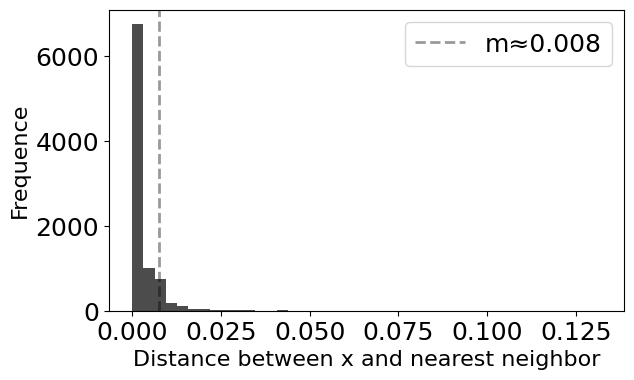

Maximum distance: 0.13
Median distance: 0.0
Center of largest bin: 0.0



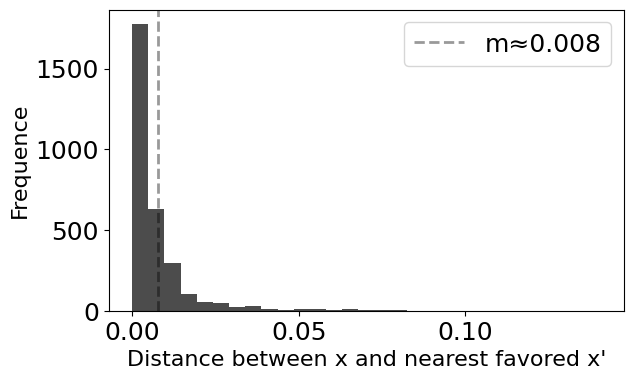

Center of largest bin: 0.0
Indices of deprived and favored instance at maximum distance of 0.14: 7935, 6776

Attribute contributions to the distance of 0.14:
[0.01783780538167468, 0.0019452887661072285, 0.0, 0.0, 0.0, 2.590884874884477e-07, 1.2211475291396728e-08, 0.0, 0.0, 0.0, 0.0]


,score_text-d,race,priors_count,age,juv_fel_count,juv_misd_count,juv_other_count,days_b_screening_arrest,c_days_from_compas,c_charge_degree,is_recid,r_charge_degree,is_violent_recid
7935,0,1,38,45,0,0,0,-1.0,1.0,2,1,1,1
6776,1,0,17,56,0,0,0,41.0,53.0,2,1,1,1


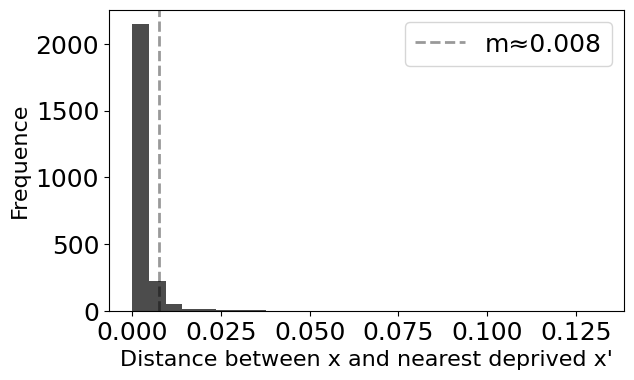

Centers of the 'modes': 0.0, 0.01, 0.01
Indices of deprived and favored instance at maximum distance of 0.13: 3480, 363

Attribute contributions to the distance of 0.13:
[0.0010112134570110364, 0.005803712764997599, 0.0, 0.0, 5.4346687868987516e-05, 0.0, 0.0, 0.010545045028834922, 0.0, 0.0, 0.0]


,score_text-d,race,priors_count,age,juv_fel_count,juv_misd_count,juv_other_count,days_b_screening_arrest,c_days_from_compas,c_charge_degree,is_recid,r_charge_degree,is_violent_recid
3480,0,1,5,25,0,0,1,-1.0,1.0,2,1,2,0
363,1,0,0,44,0,0,0,-1.0,1.0,1,1,2,0


In [34]:
m_compas = get_m(df_compas, d_matrix_compas, 'compas', bin_cols_compas, nom_cols_compas, int_cols_compas,
                 ord_cols_compas, w_compas)

Number of deprived instances with negative class label: 3027
Number of favored instances with positive class label: 2463
Number of instances with no near instance: 941 (17%)
Number of instances for which assumptions of Z-tests are not met: 2405 (44%)
Number of instances with an insignificant unfairness score: 1498 (27%)
Number of unfair instances: 646 (12%)
Number of unfair deprived instances: 221 (7%)
Q3 and IQR of D_k-scores for favored instances: 0.59, 0.35



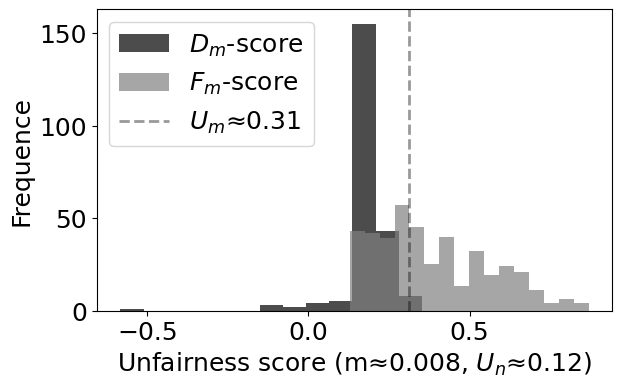

Number, mean, median, min, max of D_m-scores: 221, 0.17, 0.17, -0.58, 0.35
Number, mean, median, min, max of F_m-scores: 425, 0.38, 0.35, 0.13, 0.87


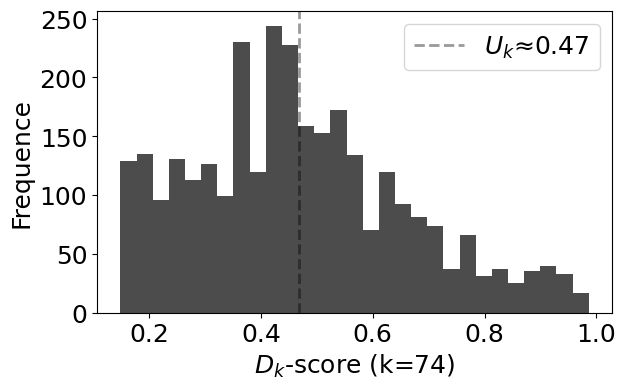

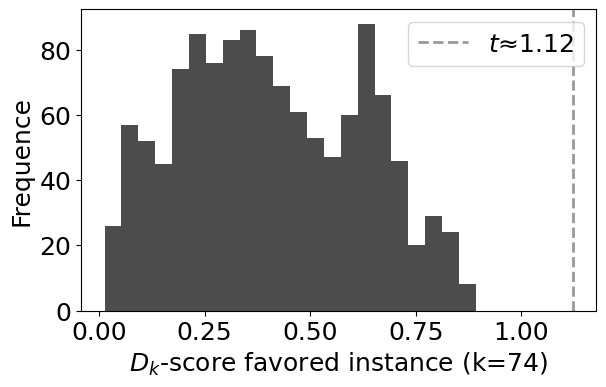

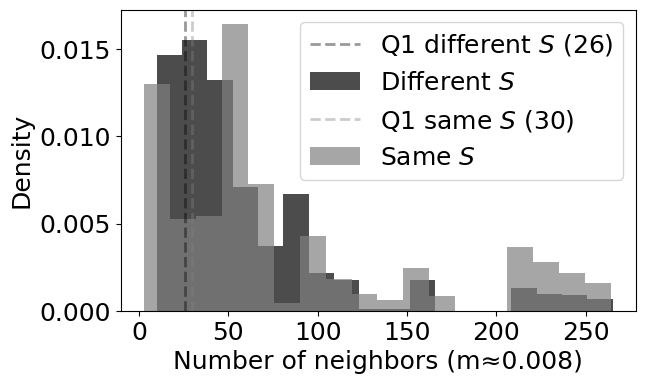

Min, max, mean, median number of neighbors of D_m-scores: 10.0, 112.0, 70, 74
Min, max, mean, median number of neighbors of F_m-scores: 10.0, 265.0, 56, 38


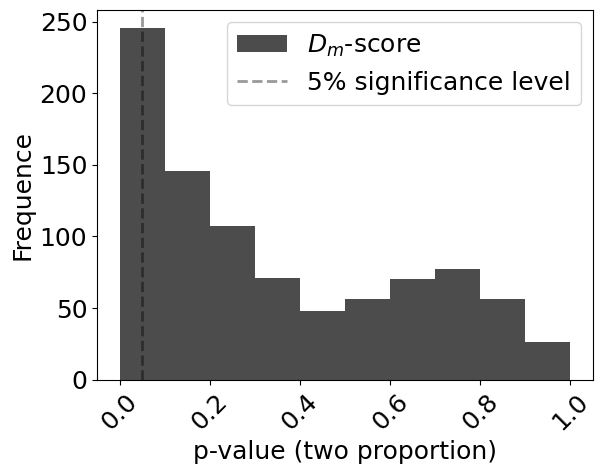

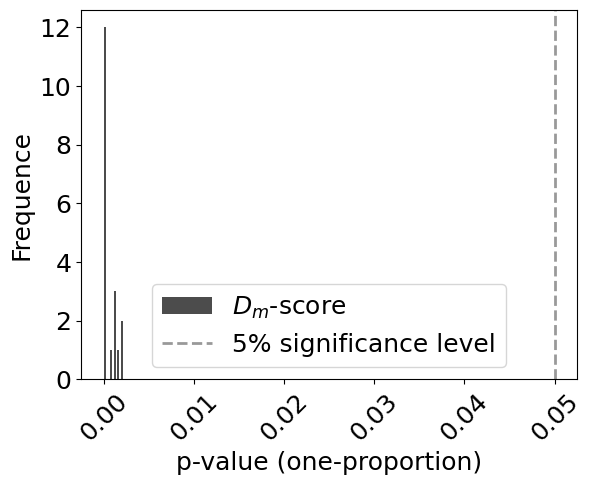

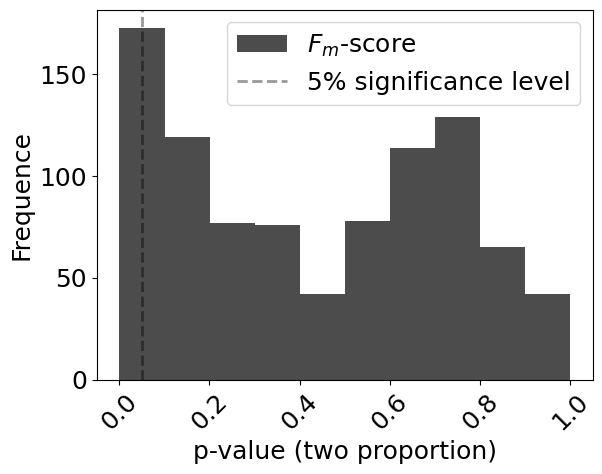

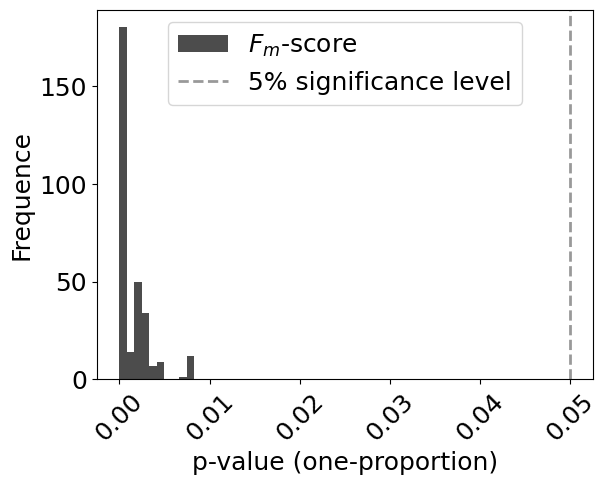

In [35]:
d_m_compas, _, _, _, _ = get_unfair_instances(df_compas.to_numpy(), d_matrix_compas, m_compas, 'compas', 74, plot=1, save=1)

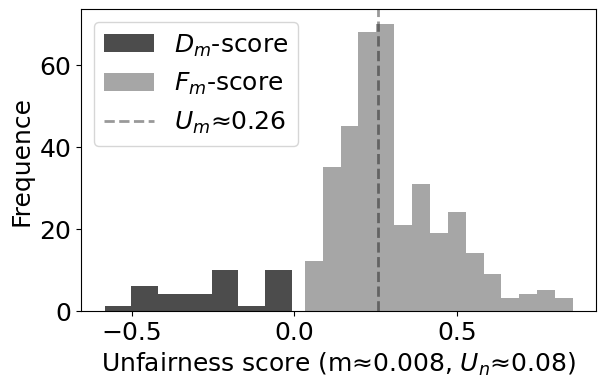

In [36]:
relabel_deprived(df_compas.to_numpy(), d_m_compas, d_matrix_compas, m_compas, 'compas_rl', 74, save=1)

In [37]:
# d_matrix_ar = np.empty(0)
# m_ar = np.nan

In [38]:
# w_ar = get_w(df_ar, bin_cols_ar, nom_cols_ar, int_cols_ar, ord_cols_ar, 'ar', save=1)[0].reshape(-1, 1)
w_ar = pd.read_excel(f'{w_path}w_ar_2887_0.09.xlsx', index_col=0)
display(w_ar.sort_values('w', ascending=False).style.background_gradient(cmap="RdYlGn"))
w_ar = w_ar.to_numpy()
# df_ar = df_ar_original.sample(frac=0.4, random_state=state).reset_index(drop=True)
d_matrix_ar = get_d_matrix(df_ar, w_ar, bin_cols_ar, nom_cols_ar, int_cols_ar, ord_cols_ar)

,w
gratification_2,0.148681
entity_type,0.094634
confidence_2,0.088628
is_too_fast,0.084807
materialism_2,0.069443
debt_attitude_2,0.064735
materialism_3,0.044712
zzz002,0.039238
financial_skills_3,0.034663
materialism_1,0.029194


Time when starting calculating d_matrix: 03:53:00
Total runtime (in minutes): 0.74


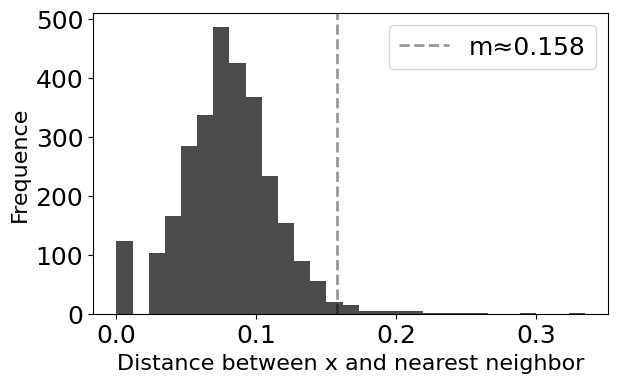

Maximum distance: 0.33
Median distance: 0.08
Center of largest bin: 0.08



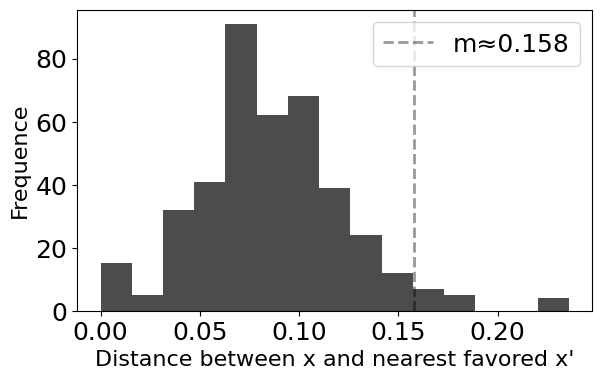

Center of largest bin: 0.07
Indices of deprived and favored instance at maximum distance of 0.24: 1477, 869

Attribute contributions to the distance of 0.24:
[0.0, 0.0, 0.0, 9.631391200951249e-16, 0.0, 1e-14, 1.004595538204099e-14, 6.272644141656253e-05, 0.0021664081019817636, 0.0, 0.00729842476368427, 0.0, 0.0, 0.0012576732889579825, 0.02215699380426473, 0.01567384192602538, 2.5001819903864724e-15, 0.0, 0.004608442999686078, 0.0, 0.0, 6.25e-16, 1e-14, 1e-14, 0.0024523793417597587]


,entity_status,lang,entity_type,is_too_fast,is_team_work,age,social_desirability_1,social_desirability_2,social_desirability_3,financial_skills_2,...,confidence_3,debt_attitude_1,debt_attitude_2,debt_attitude_3,gratification_1,gratification_2,gratification_3,reasoning_3,reasoning_4,zzz002
1477,0,1,0,0,0,36.0,0,0,0,3,...,0,2,0,1,0,1,0,1,5,4
869,0,0,0,0,0,54.0,0,1,1,0,...,3,0,0,3,0,1,1,6,3,3


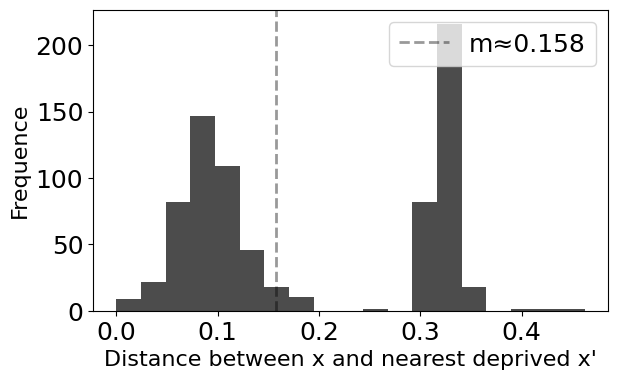

Centers of the 'modes': 0.33, 0.09, 0.11
Indices of deprived and favored instance at maximum distance of 0.46: 1336, 824

Attribute contributions to the distance of 0.46:
[0.09463447715089263, 0.08480749407499287, 0.0, 7.431629013079668e-17, 0.0, 1e-14, 0.0, 0.0001115136736294445, 0.0021664081019817636, 0.007439105770145106, 0.0, 0.004340179268494191, 0.002794469332595785, 0.0012576732889579825, 0.0, 0.0017415379917805976, 0.0, 0.004045964525329965, 0.0011521107499215194, 5.625e-15, 0.009292550294897044, 6.25e-16, 1e-14, 1e-14, 0.0]


,entity_status,lang,entity_type,is_too_fast,is_team_work,age,social_desirability_1,social_desirability_2,social_desirability_3,financial_skills_2,...,confidence_3,debt_attitude_1,debt_attitude_2,debt_attitude_3,gratification_1,gratification_2,gratification_3,reasoning_3,reasoning_4,zzz002
1336,0,1,0,0,0,25.0,1,1,1,0,...,3,4,3,3,1,3,3,7,6,4
824,1,0,1,1,0,30.0,1,0,1,4,...,4,4,4,4,4,4,4,5,5,4


In [39]:
m_ar = get_m(df_ar, d_matrix_ar, 'ar', bin_cols_ar, nom_cols_ar, int_cols_ar, ord_cols_ar, w_ar)

Number of deprived instances with negative class label: 405
Number of favored instances with positive class label: 763
Number of instances with no near instance: 356 (30%)
Number of instances for which assumptions of Z-tests are not met: 342 (29%)
Number of instances with an insignificant unfairness score: 44 (4%)
Number of unfair instances: 426 (36%)
Number of unfair deprived instances: 300 (74%)
Q3 and IQR of D_k-scores for favored instances: 0.15, 0.04



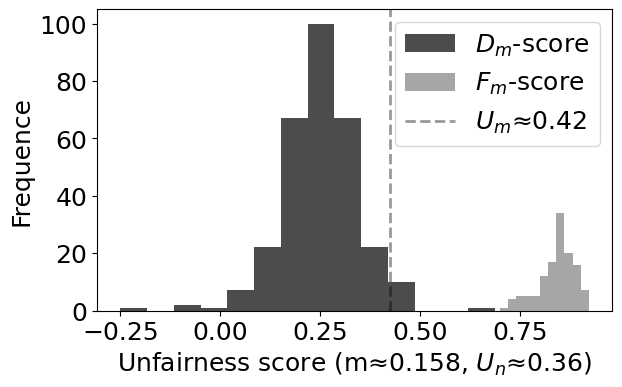

Number, mean, median, min, max of D_m-scores: 300, 0.25, 0.25, -0.25, 0.69
Number, mean, median, min, max of F_m-scores: 126, 0.84, 0.85, 0.7, 0.92


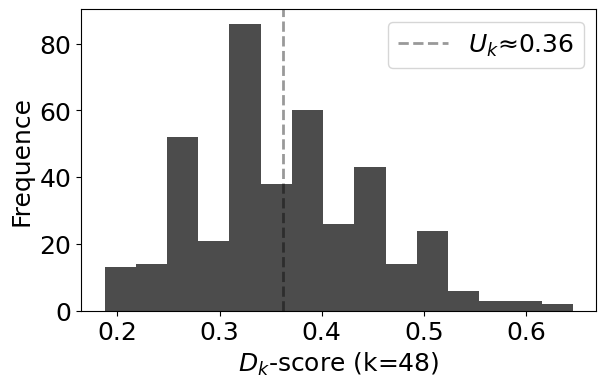

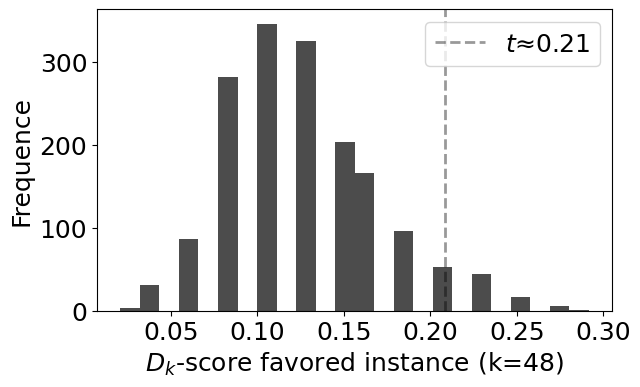

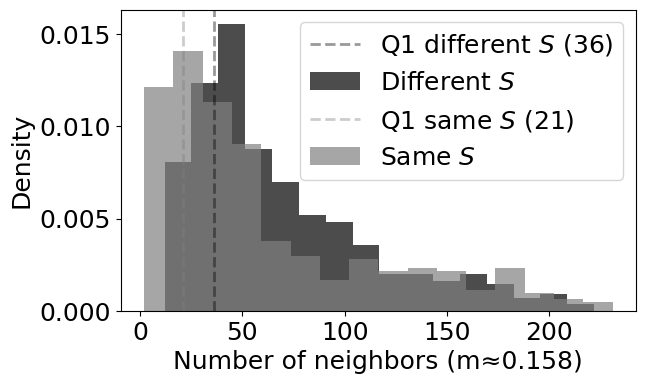

Min, max, mean, median number of neighbors of D_m-scores: 12.0, 222.0, 79, 69
Min, max, mean, median number of neighbors of F_m-scores: 19.0, 79.0, 45, 45


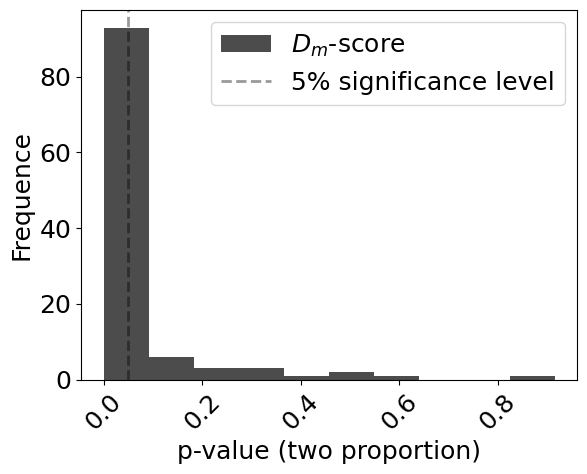

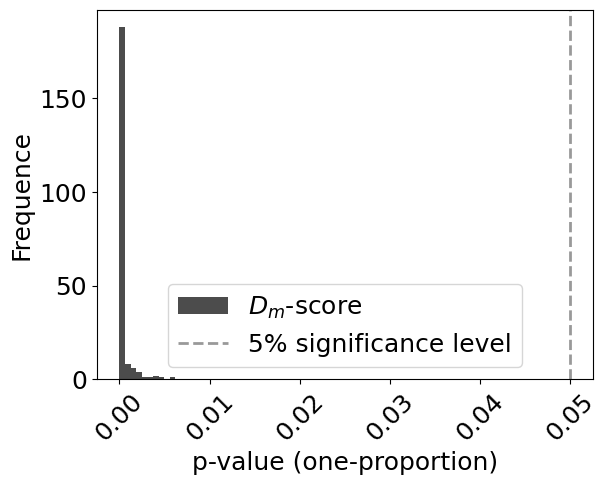

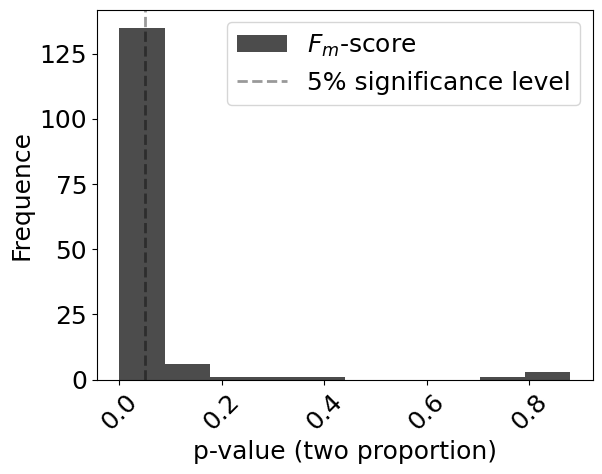


Assumptions for the one-proportion test for all favored instances are not met


In [40]:
d_m_ar, _, _, _, _ = get_unfair_instances(df_ar.to_numpy(), d_matrix_ar, m_ar, 'ar_rl', 48, plot=1, save=1)

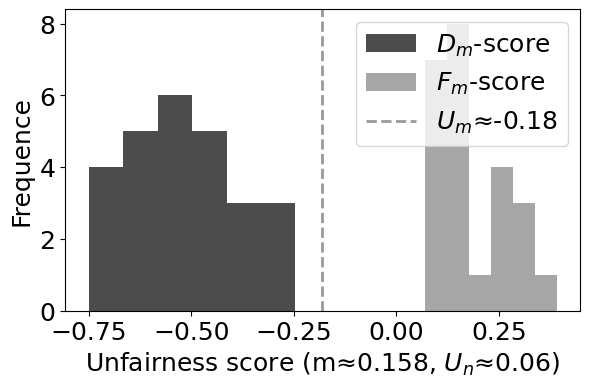

In [41]:
relabel_deprived(df_ar.to_numpy(), d_m_ar, d_matrix_ar, m_ar, 'ar', 48, save=1)

### Visualize group comparisons

In [42]:
df_compas[['priors_count', 'age']].min()

priors_count     0
age             18
dtype: int64

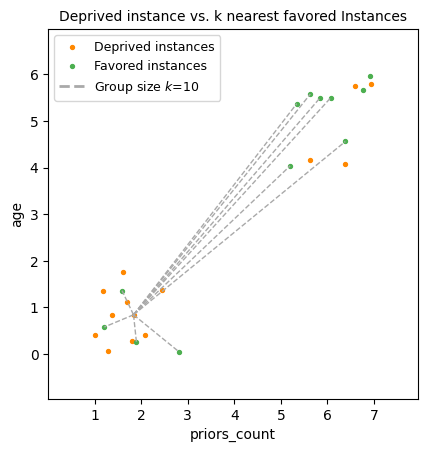

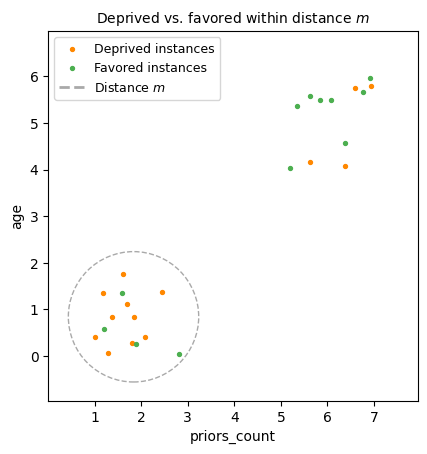

In [43]:
def plot_fairness_comparison(deprived_instances, favored_instances, k, title='', seed=0):
    """
    This function simulates and visualizes the distribution of deprived and favored instances in a 2D space. 
    It provides a visual representation of how favored instances relate to deprived instances in terms of proximity 
    or group size.

    :param deprived_instances: list of sublists, each containing [x, y, n] where x, y are the coordinates 
    and n is the number of deprived instances to simulate around that point.
    :param favored_instances: list of sublists, each containing [x, y, n] where x, y are the coordinates 
    and n is the number of favored instances to simulate around that point.
    :param k: number of nearest favored instances to consider or used as a threshold for distance. 
    If k is 0, the function will display instances within a certain distance.
    :param title: title of the plot (default='').
    :param seed: random seed for reproducibility (default=0).
    """

    np.random.seed(seed)

    all_x = []
    all_y = []
    first_coordinates = []
    favored_coordinates = []

    deprived_color = '#FF8800'
    favored_color = '#4CAF50'
    distance_color = '#A9A9A9'

    radius = 1.4
    markersize = 8
    fontsize = 10
    first_deprived = True
    first_favored = True

    fig, ax = plt.subplots()

    for i, (x_center, y_center, n) in enumerate(deprived_instances):
        x_positions = np.random.uniform(low=x_center - 1, high=x_center + 1, size=n)
        y_positions = np.random.uniform(low=y_center - 1, high=y_center + 1, size=n)

        all_x.extend(x_positions)
        all_y.extend(y_positions)

        scatter = ax.scatter(x_positions, y_positions, color=deprived_color, s=markersize,
                             label='Deprived instances' if first_deprived else "")

        if first_deprived:
            first_deprived = False
            if k == 0:
                ax.add_patch(plt.Circle((x_positions[0], y_positions[0]), radius, fill=False, linestyle='--',
                                        color=distance_color))
            else:
                first_coordinates.append([x_positions[0], y_positions[0]])

    for i, (x_center, y_center, n) in enumerate(favored_instances):
        x_positions = np.random.uniform(low=x_center - 1, high=x_center + 1, size=n)
        y_positions = np.random.uniform(low=y_center - 1, high=y_center + 1, size=n)

        all_x.extend(x_positions)
        all_y.extend(y_positions)

        ax.scatter(x_positions, y_positions, color=favored_color, s=markersize,
                   label='Favored instances' if first_favored else "")
        if first_favored:
            first_favored = False

        for x, y in zip(x_positions, y_positions):
            favored_coordinates.append((x, y))

    if first_coordinates:
        distances = [(np.sqrt((x - first_coordinates[0][0]) ** 2 + (y - first_coordinates[0][1]) ** 2), (x, y))
                     for (x, y) in favored_coordinates]
        closest_instances = [coord for _, coord in sorted(distances, key=lambda item: item[0])[:k]]
        for coord in closest_instances:
            plt.plot([first_coordinates[0][0], coord[0]], [first_coordinates[0][1], coord[1]], color=distance_color,
                     linestyle='--', linewidth=1)

    ax.set_xlim(min(all_x) - 1, max(all_x) + 1)
    ax.set_ylim(min(all_y) - 1, max(all_y) + 1)

    distance_label = f'Distance $m$' if k == 0 else f'Group size $k$={k}'
    ax.plot([], [], linestyle='--', color=distance_color, label=distance_label)

    ax.legend(loc='best', frameon=True, fontsize=9)
    ax.set_aspect('equal', 'box')
    plt.title(title, fontsize=fontsize)
    ax.set_xlabel("priors_count", fontsize=fontsize)
    ax.set_ylabel("age", fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=10)
    plt.show()


plot_fairness_comparison([[2, 1, 10], [6, 5, 4]], [[6, 5, 8], [2, 1, 4]], 10,
                         'Deprived instance vs. k nearest favored Instances', 1)
plot_fairness_comparison([[2, 1, 10], [6, 5, 4]], [[6, 5, 8], [2, 1, 4]], 0, 'Deprived vs. favored within distance $m$',
                         1)


# CDP (multiple explanatory attributes)

C:\Users\tirit\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\tirit\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


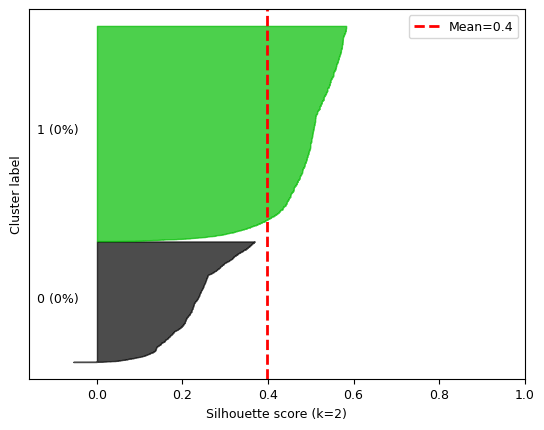

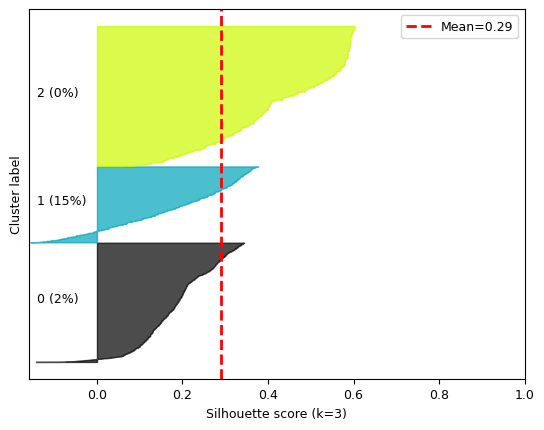

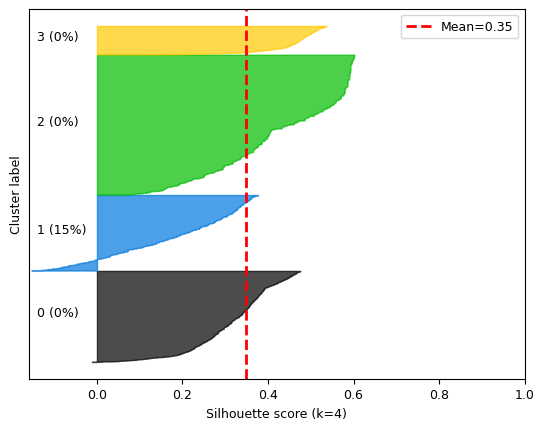

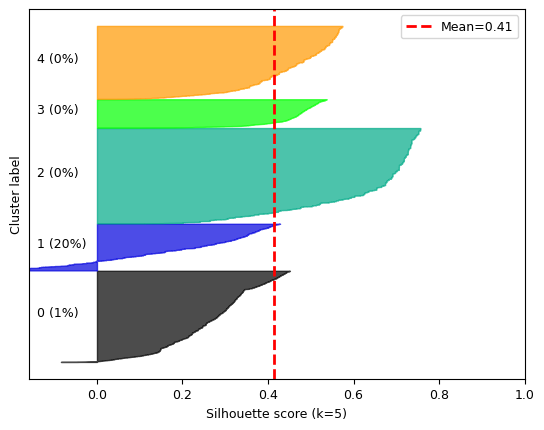

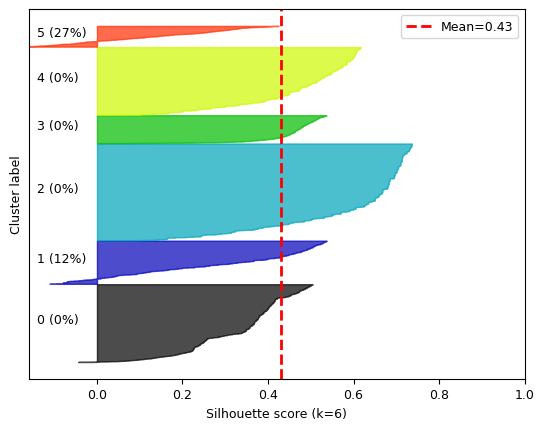

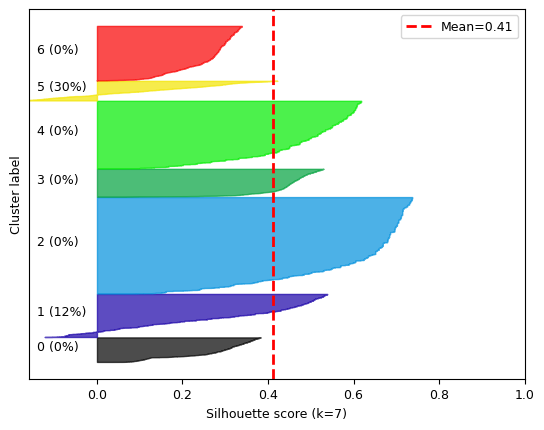

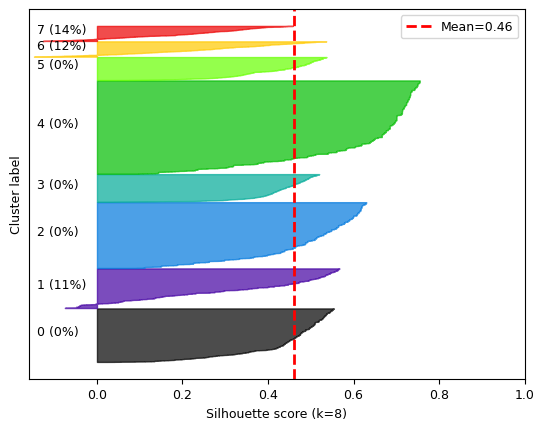

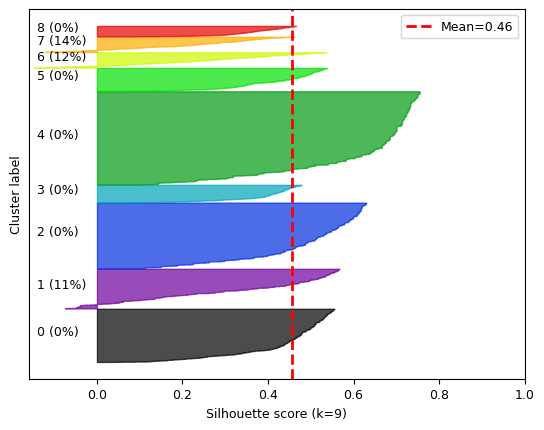

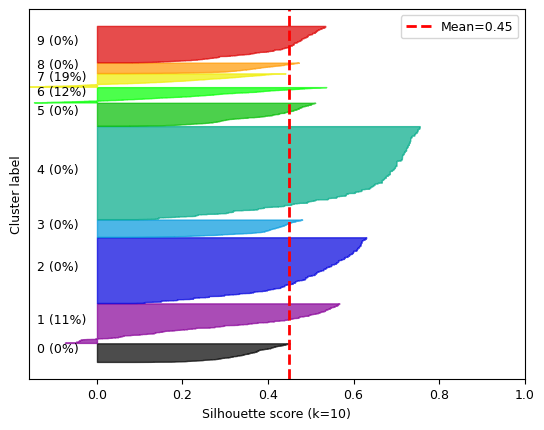

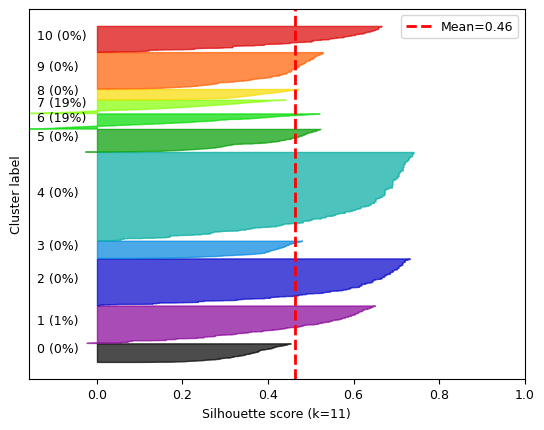

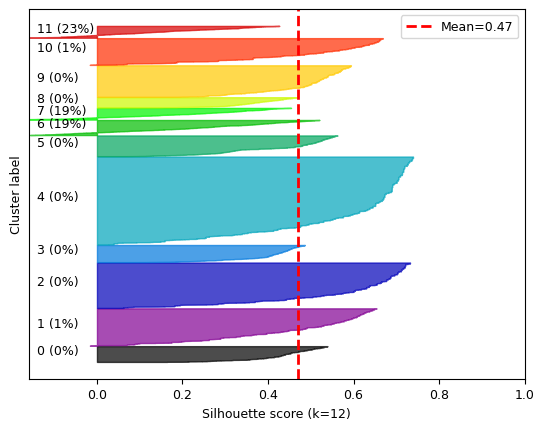

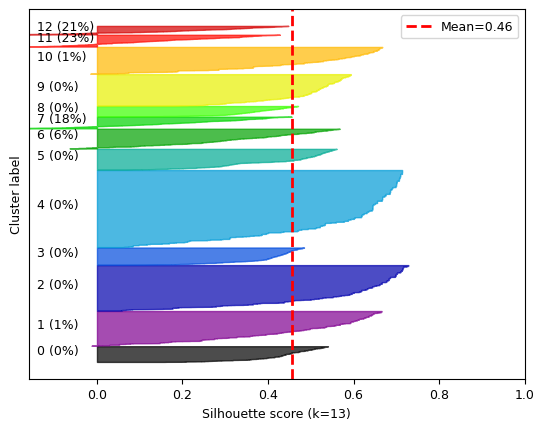

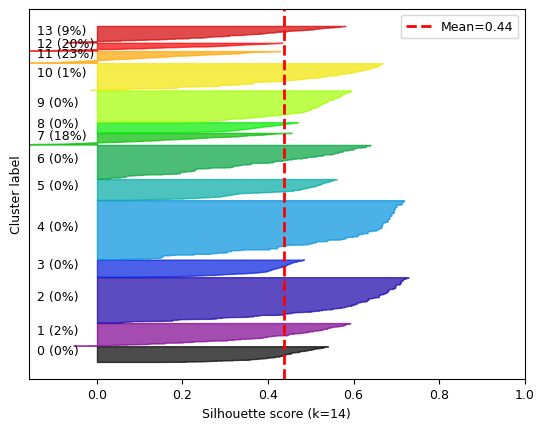

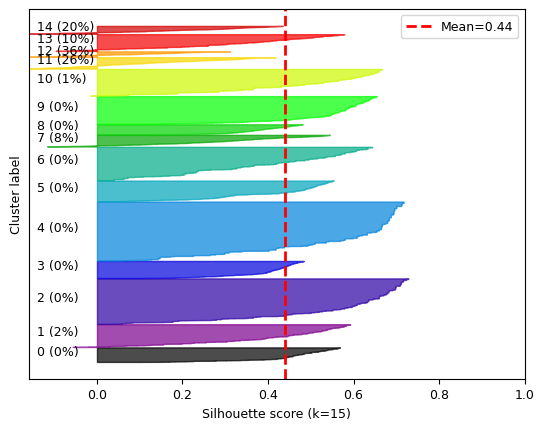

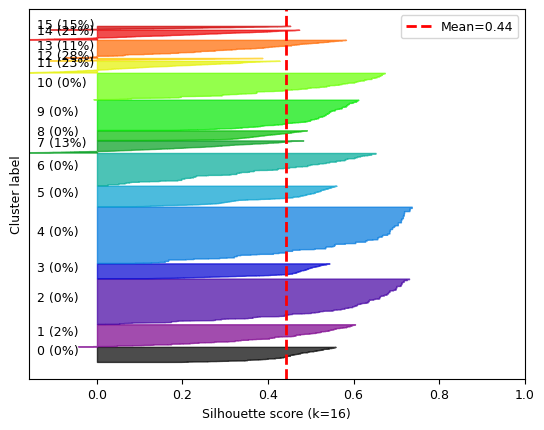

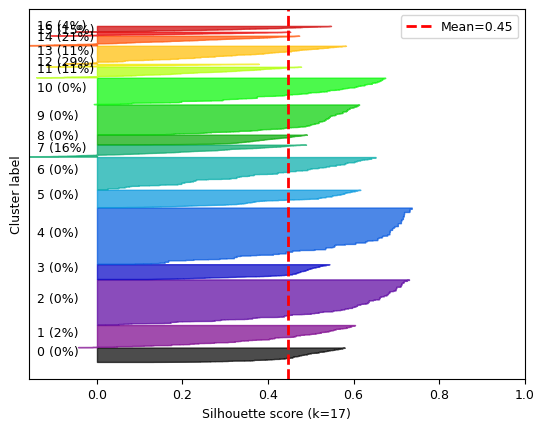

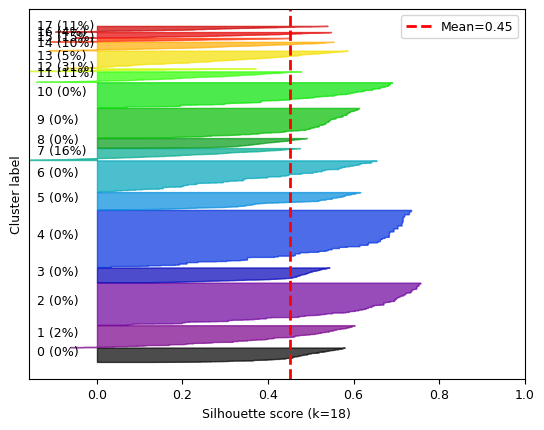

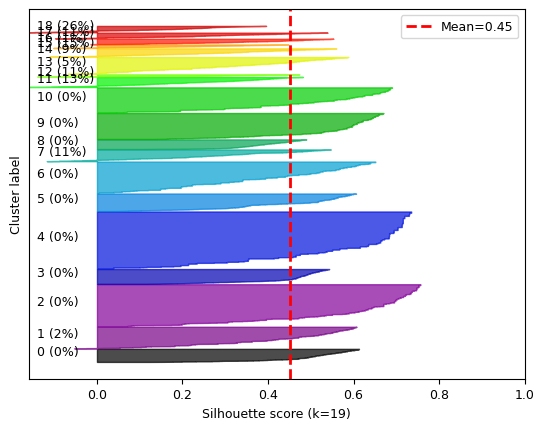

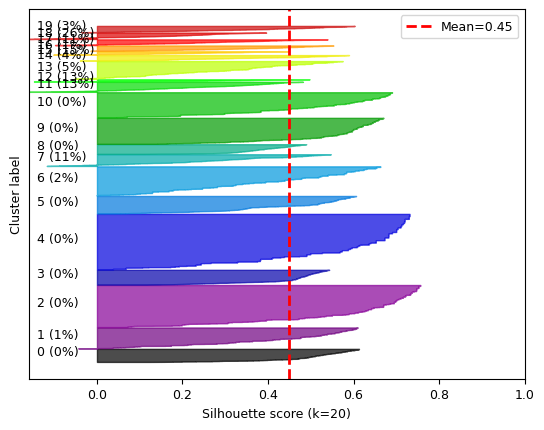

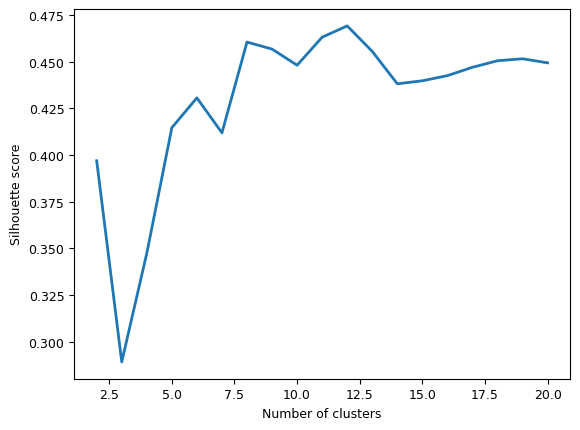

Silhouette scores:
[0.3969482900675738, 0.2892415690591793, 0.3474421119412804, 0.4146561546858204, 0.430618569082821, 0.4119029890154142, 0.4604938912274896, 0.4567233941159057, 0.4480929426627833, 0.4631024458542441, 0.46913148885971356, 0.45549281569307093, 0.4381567457887846, 0.43975424992785356, 0.4425184267375779, 0.44698251383886867, 0.4504962836668396, 0.4515510667389828, 0.4493677652775183]

Silhouette score for k=8: 0.46
D_all in each cluster: [0.25, 0.13, 0.14, 0.21, 0.14, 0.21, 0.12, 0.17]
D_u in each cluster: [0.21, 0.11, 0.11, 0.17, 0.11, 0.15, 0.1, 0.13]
Cluster sizes:
cluster
4    2503
2    1767
0    1436
1    1064
3     743
5     618
6     411
7     404
Name: count, dtype: int64


In [44]:
df_compas_clustered = cdp_me(df_compas, w_compas, cat_cols_compas, nom_cols_compas, 8, [6])

In [45]:
get_cluster_info(df_compas_clustered, w_compas, bin_cols_compas, nom_cols_compas, int_cols_compas, ord_cols_compas,
                 d_matrix_compas, m_compas, 'compas', 74, 0)

Indices of deprived and favored instance at maximum distance of 0.33: 3872, 5226

Attribute contributions to the distance of 0.33:
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.471458443033689e-11, 0.0, 0.0, 0.10826675140846315, 0.0]


,score_text-d,race,priors_count,age,juv_fel_count,juv_misd_count,juv_other_count,days_b_screening_arrest,c_days_from_compas,c_charge_degree,is_recid,r_charge_degree,is_violent_recid
3872,0,1,7,27,0,0,0,-1.0,1.0,2,1,0,0
5226,0,0,7,27,0,0,0,-1.0,3.0,2,1,1,0


,cluster label,cluster size,deprived,favored,no neighbors,assumptions unmet,insignificant,unfair instances,maximum distance (deprived),maximum distance (favored)
0,3,743,386,115,350,151,0,0,0.08,0.10
1,0,1436,643,221,251,579,15,19,0.33,0.07
2,7,404,284,21,272,33,0,0,0.29,0.03
3,2,1767,323,766,126,695,148,120,0.07,0.07
4,4,2503,806,591,197,788,293,119,0.06,0.01
5,5,618,203,167,183,170,8,9,0.03,0.33
6,1,1064,106,554,68,553,0,39,0.01,0.02
7,6,411,276,28,208,96,0,0,0.06,0.03


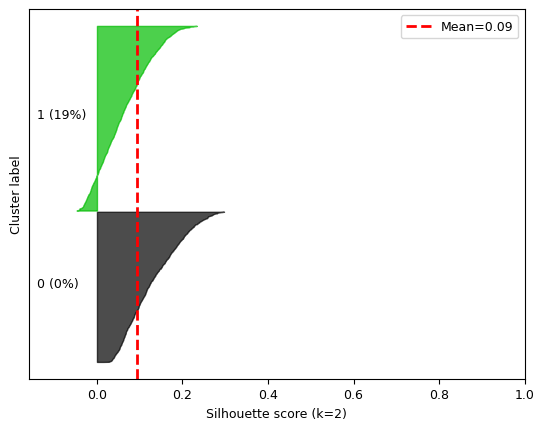

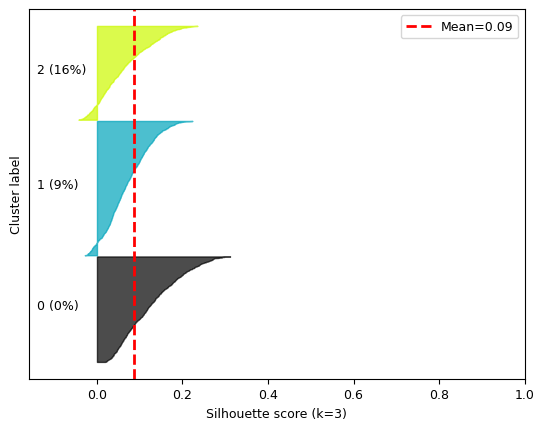

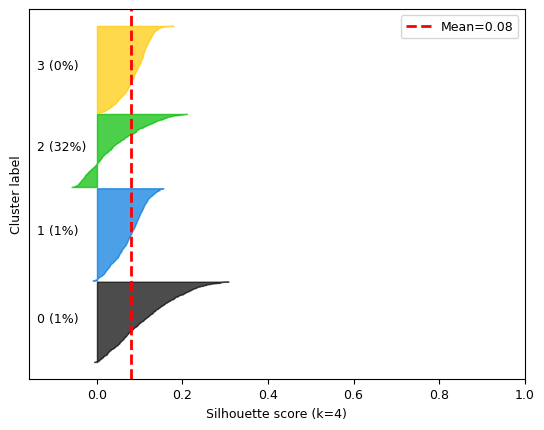

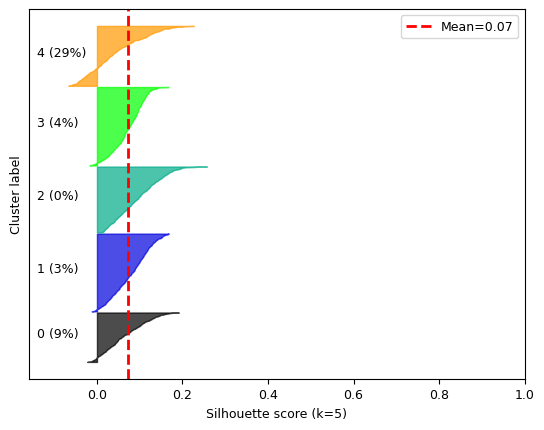

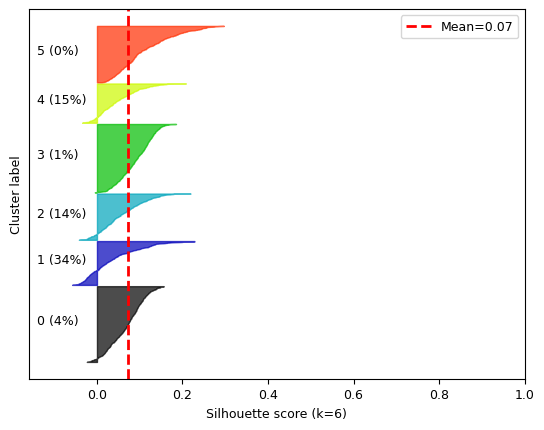

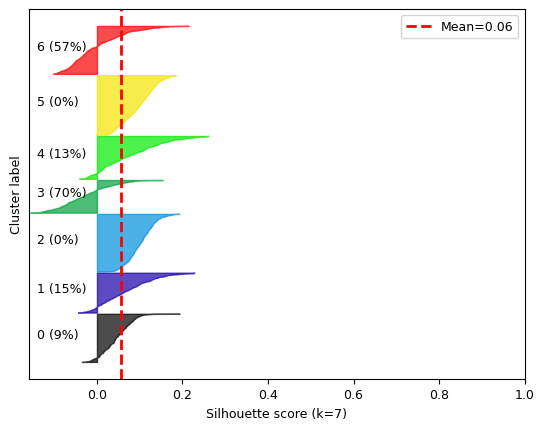

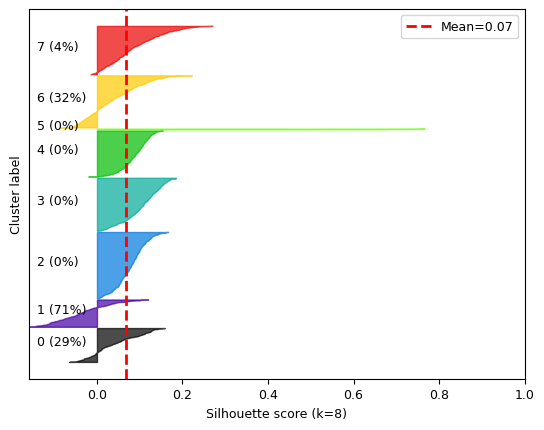

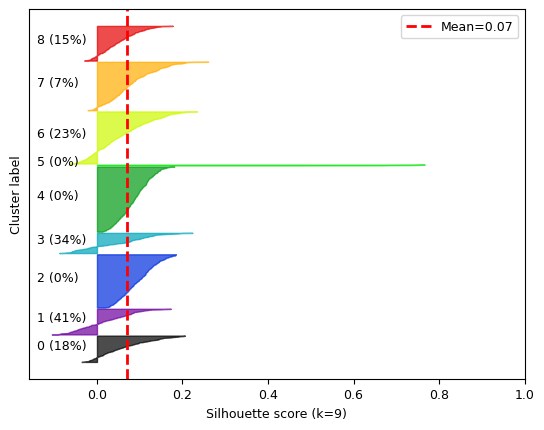

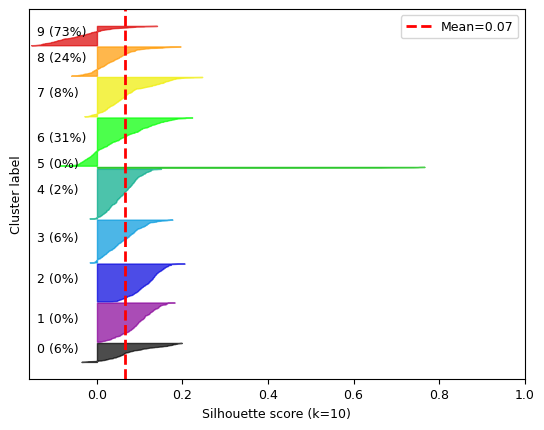

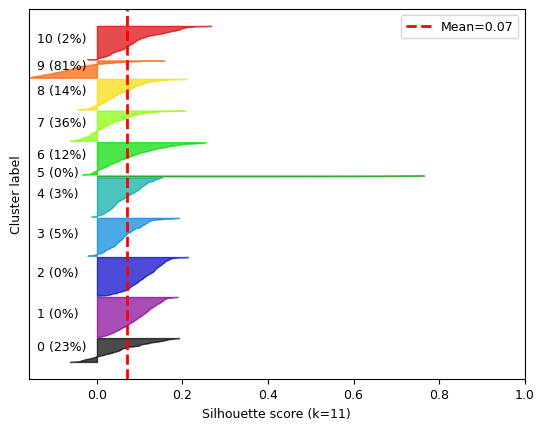

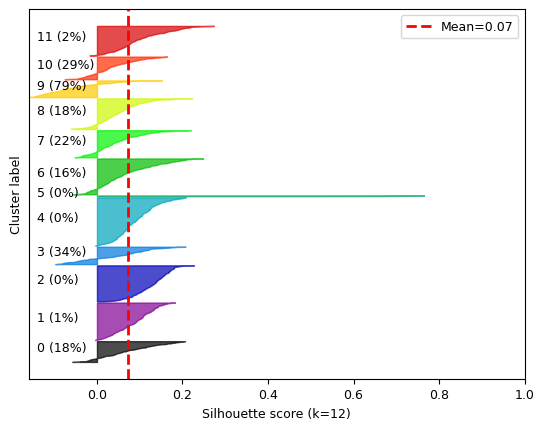

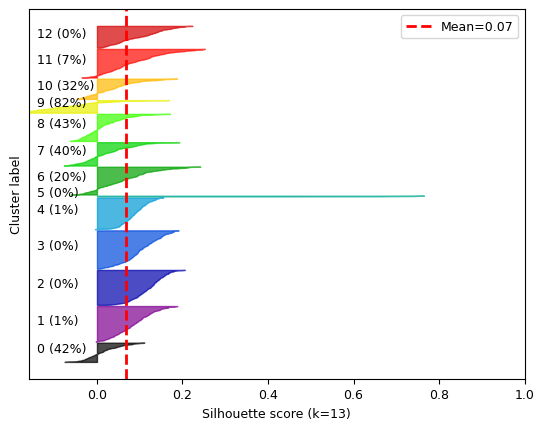

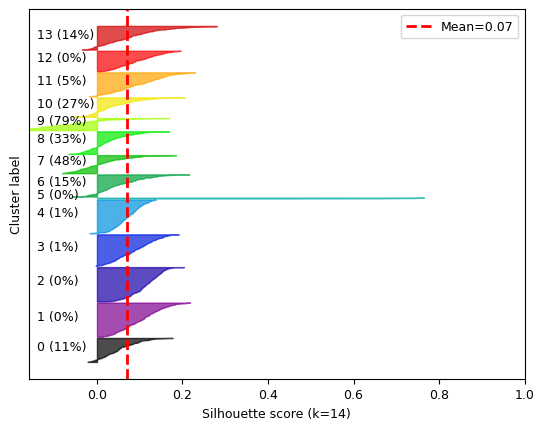

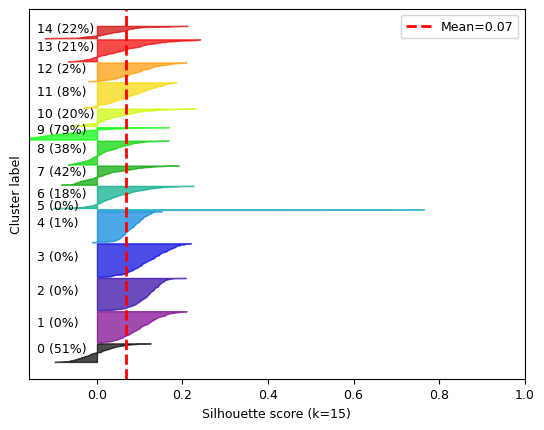

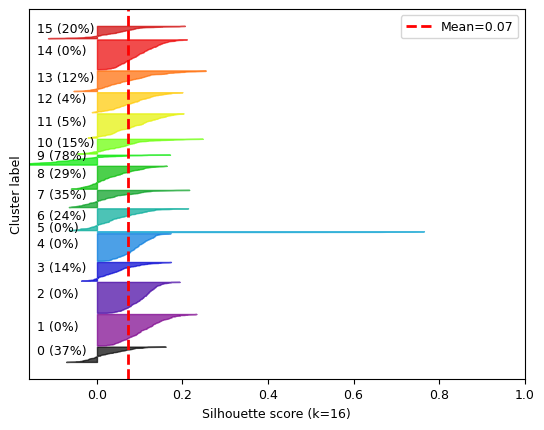

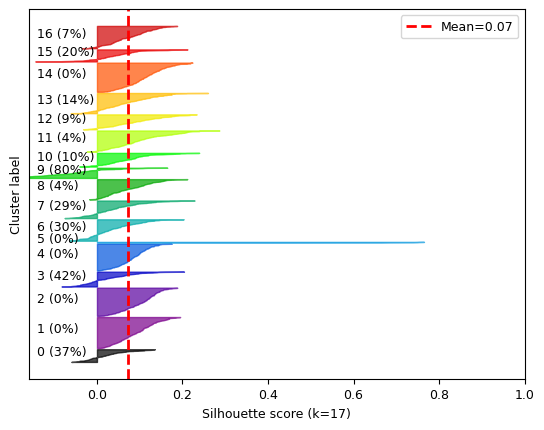

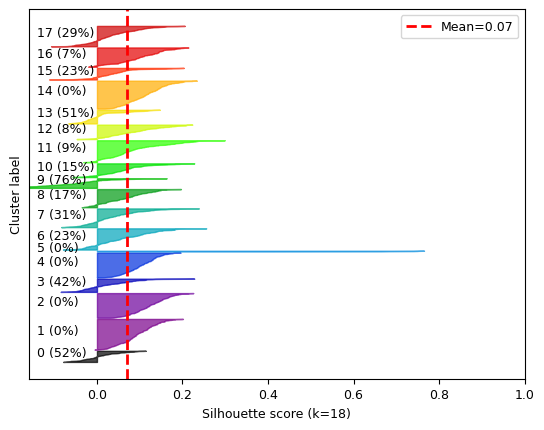

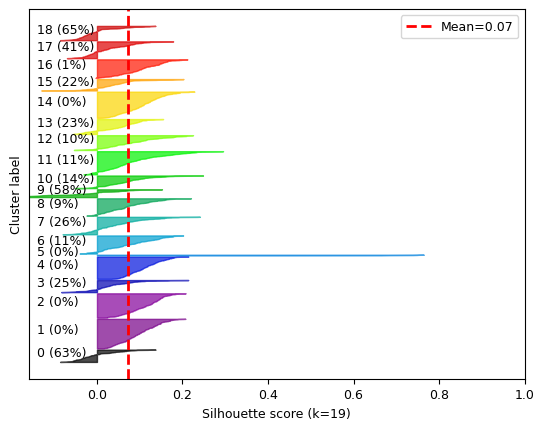

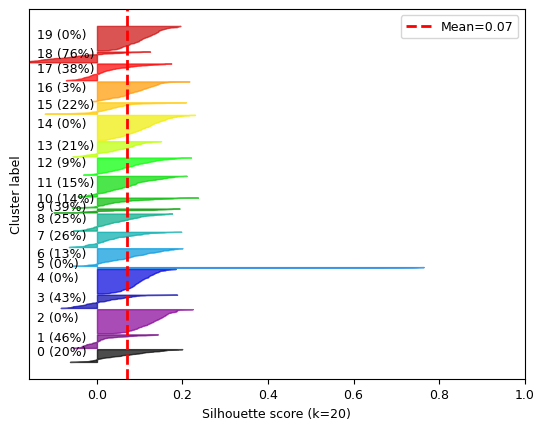

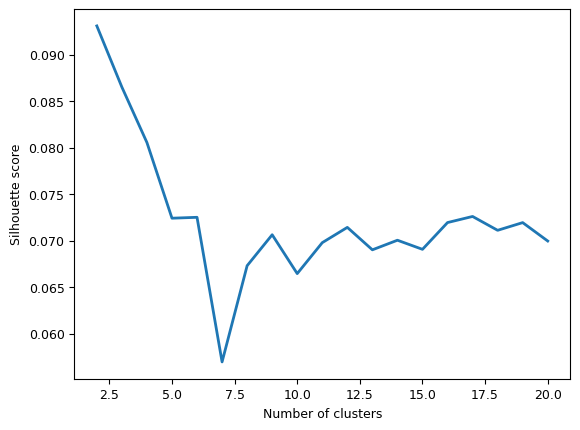

Silhouette scores:
[0.09308207094012887, 0.0865040633066463, 0.08054048408230918, 0.0724036201477332, 0.07249957527525351, 0.05694748817300382, 0.0672941306770213, 0.07062454544819888, 0.06644597989868858, 0.06977428955216648, 0.07141670112602354, 0.06900351775850637, 0.07003537362556979, 0.06905570451667332, 0.07193537825672743, 0.07259106007128184, 0.07110170889632593, 0.07192973087759892, 0.06994958545050384]

Silhouette score for k=2: 0.09
D_all in each cluster: [0.2, 0.16]
D_u in each cluster: [0.26, 0.22]
Cluster sizes:
cluster
1    1592
0    1295
Name: count, dtype: int64


In [46]:
df_ar_clustered = cdp_me(df_ar, w_ar, cat_cols_ar, nom_cols_ar, 2)

In [47]:
get_cluster_info(df_ar_clustered, w_ar, bin_cols_ar, nom_cols_ar, int_cols_ar, ord_cols_ar, d_matrix_ar, m_ar, 'ar', 48,
                 0, 0)


Indices of deprived and favored instance at maximum distance of 0.36: 1560, 474

Attribute contributions to the distance of 0.36:
[0.09463447715089263, 0.0, 0.0, 1.9698368728839642e-16, 0.0, 0.0, 0.0, 6.272644141656253e-05, 0.0, 0.0008265673077939007, 0.0018246061909210675, 0.017360717073976763, 0.0, 0.0012576732889579825, 0.0, 0.0, 6.250454975966181e-16, 0.004045964525329965, 0.0011521107499215194, 1e-14, 0.009292550294897044, 6.25e-16, 0.0, 0.0, 0.0]


,entity_status,lang,entity_type,is_too_fast,is_team_work,age,social_desirability_1,social_desirability_2,social_desirability_3,financial_skills_2,...,confidence_3,debt_attitude_1,debt_attitude_2,debt_attitude_3,gratification_1,gratification_2,gratification_3,reasoning_3,reasoning_4,zzz002
1560,0,1,0,0,0,35.0,1,1,1,3,...,4,1,1,1,0,1,1,2,4,4
474,1,0,1,0,0,27.0,1,1,1,0,...,4,0,0,2,4,0,0,2,4,4


,cluster label,cluster size,deprived,favored,no neighbors,assumptions unmet,insignificant,unfair instances,maximum distance (deprived),maximum distance (favored)
0,0,1295,164,423,159,237,19,172,0.23,0.36
1,1,1592,241,340,200,199,5,177,0.24,0.46
